# Credit Classification Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [31]:
def check_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Dupes {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels= unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.ylabel("Frequency")
  plt.show()

def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df,agg_col, col, function):
  
  plt.figure(figsize=(10,7))

  grouped_df = getattr(df.groupby(agg_col)[col],function)().reset_index(name=col)
  sns.barplot(data=grouped_df, x=agg_col, y=col)
  plt.title(f"Agg of {col}")
  plt.ylabel(col)
  plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", MinMaxScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='macro')
    precision_metric = precision_score(y, predictions, average='macro')
    f1_metric = f1_score(y, predictions, average='macro')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/train.csv")
df

ID  Customer_ID  Month           Name   Age          SSN  \
0        5634         3392      1  Aaron Maashoh  23.0  821000265.0   
1        5635         3392      2  Aaron Maashoh  23.0  821000265.0   
2        5636         3392      3  Aaron Maashoh  23.0  821000265.0   
3        5637         3392      4  Aaron Maashoh  23.0  821000265.0   
4        5638         3392      5  Aaron Maashoh  23.0  821000265.0   
...       ...          ...    ...            ...   ...          ...   
99995  155625        37932      4          Nicks  25.0   78735990.0   
99996  155626        37932      5          Nicks  25.0   78735990.0   
99997  155627        37932      6          Nicks  25.0   78735990.0   
99998  155628        37932      7          Nicks  25.0   78735990.0   
99999  155629        37932      8          Nicks  25.0   78735990.0   

      Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      Scientist       19114.12            1824.843333                3.0   
1      Scientist       19114.12            1824.843333                3.0   
2      Scientist       19114.12            1824.843333                3.0   
3      Scientist       19114.12            1824.843333                3.0   
4      Scientist       19114.12            1824.843333                3.0   
...          ...            ...                    ...                ...   
99995   Mechanic       39628.99            3359.415833                4.0   
99996   Mechanic       39628.99            3359.415833                4.0   
99997   Mechanic       39628.99            3359.415833                4.0   
99998   Mechanic       39628.99            3359.415833                4.0   
99999   Mechanic       39628.99            3359.415833                4.0   

       ...  Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio  \
0      ...        Good            809.98                 26.822620   
1      ...        Good            809.98                 31.944960   
2      ...        Good            809.98                 28.609352   
3      ...        Good            809.98                 31.377862   
4      ...        Good            809.98                 24.797347   
...    ...         ...               ...                       ...   
99995  ...        Good            502.38                 34.663572   
99996  ...        Good            502.38                 40.565631   
99997  ...        Good            502.38                 41.255522   
99998  ...        Good            502.38                 33.638208   
99999  ...        Good            502.38                 34.192463   

      Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
0                  265.0                     No            49.574949   
1                  266.0                     No            49.574949   
2                  267.0                     No            49.574949   
3                  268.0                     No            49.574949   
4                  269.0                     No            49.574949   
...                  ...                    ...                  ...   
99995              378.0                     No            35.104023   
99996              379.0                     No            35.104023   
99997              380.0                     No            35.104023   
99998              381.0                     No            35.104023   
99999              382.0                     No            35.104023   

       Amount_invested_monthly                 Payment_Behaviour  \
0                    21.465380   High_spent_Small_value_payments   
1                    21.465380    Low_spent_Large_value_payments   
2                    21.465380   Low_spent_Medium_value_payments   
3                    21.465380    Low_spent_Small_value_payments   
4                    21.465380  High_spent_Medium_value_payments   
...                        ...                               ...   
99995                24.028477   High_spent_Large_v

In [4]:
df.drop(["ID", "Name", "Customer_ID", "SSN", "Month", "Type_of_Loan"], axis=1, inplace=True)

# Check For Nulls and Dupes

In [5]:
check_nulls_dupes(df)

The amount of Nulls: Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64
The amount of Dupes 0


# Check Class Imbalance

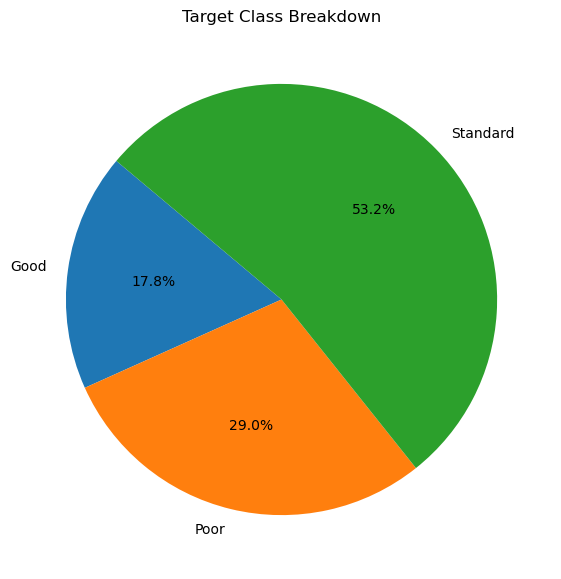

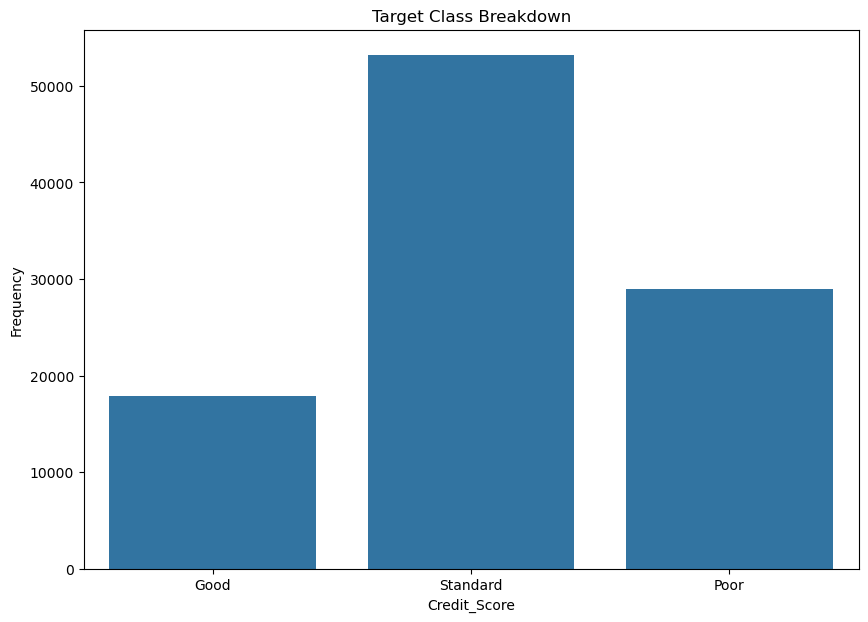

In [6]:
check_class_imbalance(df["Credit_Score"])

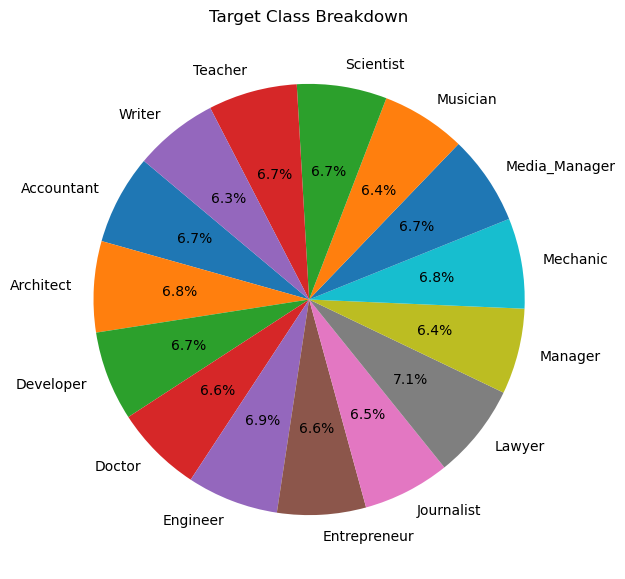

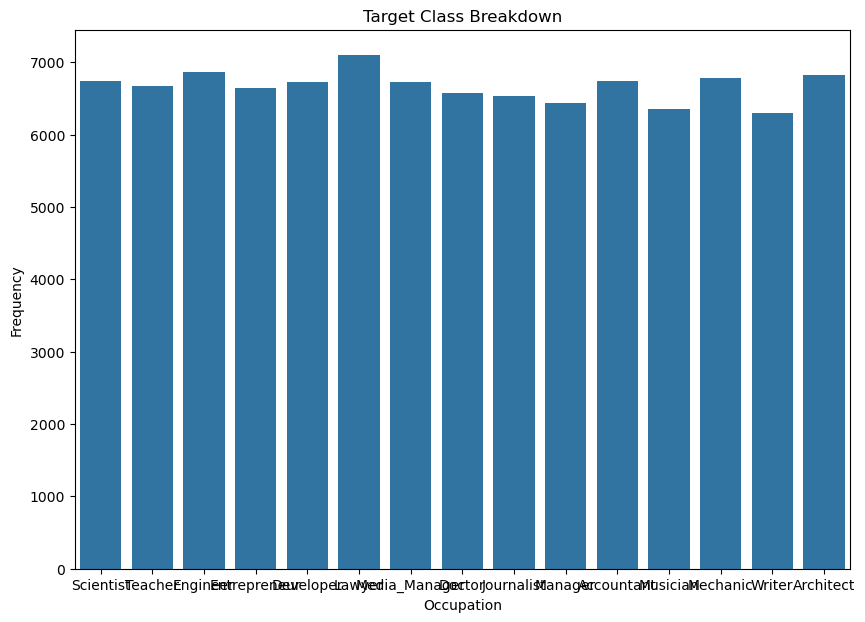

In [7]:
check_class_imbalance(df["Occupation"])

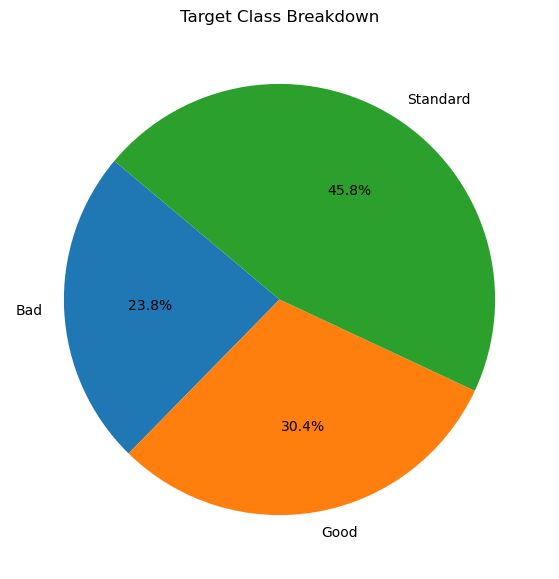

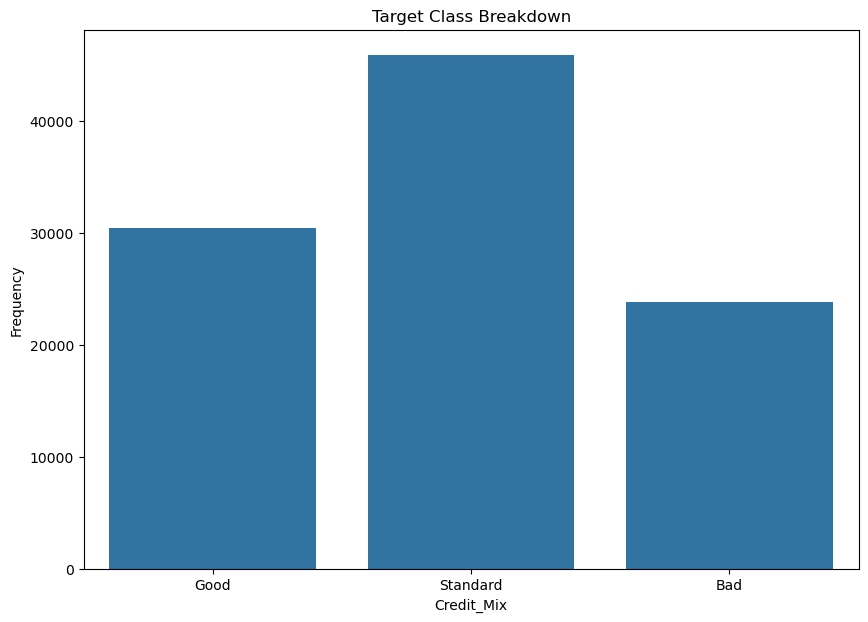

In [8]:
check_class_imbalance(df["Credit_Mix"])

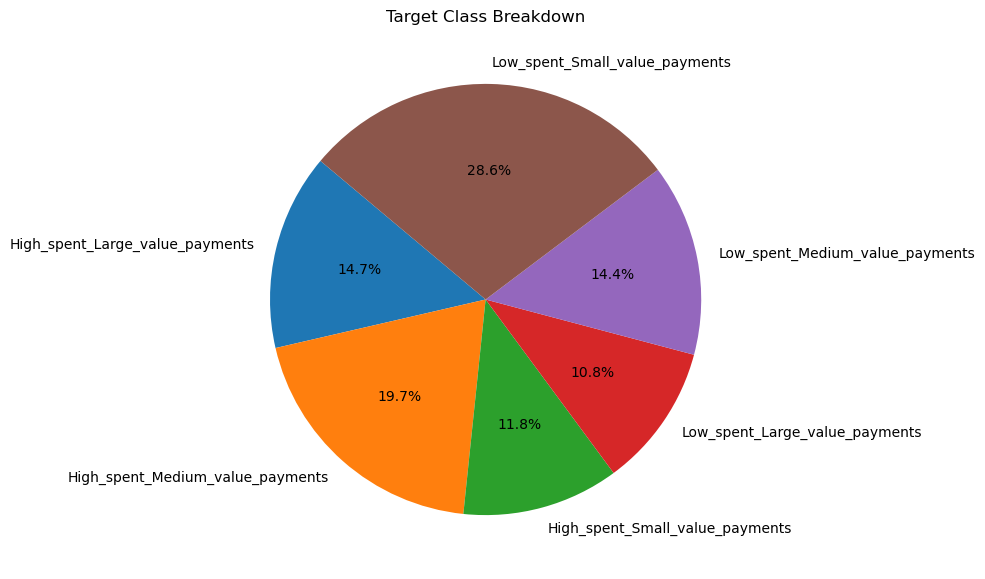

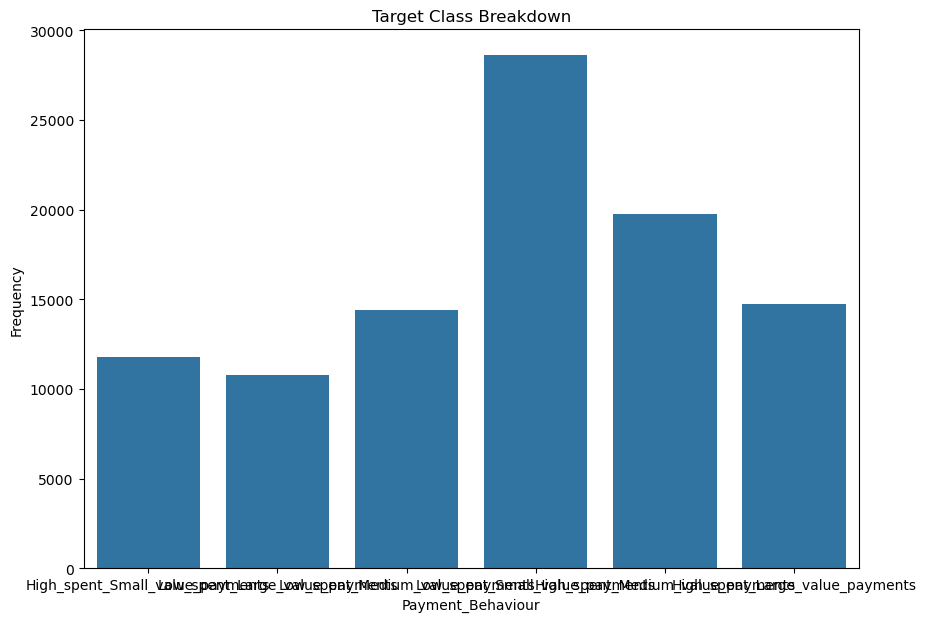

In [9]:
check_class_imbalance(df["Payment_Behaviour"])

In [10]:
df.dtypes

Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts           float64
Num_Credit_Card             float64
Interest_Rate               float64
Num_of_Loan                 float64
Delay_from_due_date         float64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
dtype: object

In [11]:
df.describe()

Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  100000.000000  100000.000000          100000.000000      100000.000000   
mean       33.316340   50505.123449            4197.270835           5.368820   
std        10.764812   38299.422093            3186.432497           2.593314   
min        14.000000    7005.930000             303.645417           0.000000   
25%        24.000000   19342.972500            1626.594167           3.000000   
50%        33.000000   36999.705000            3095.905000           5.000000   
75%        42.000000   71683.470000            5957.715000           7.000000   
max        56.000000  179987.280000           15204.633333          11.000000   

       Num_Credit_Card  Interest_Rate    Num_of_Loan  Delay_from_due_date  \
count    100000.000000   100000.00000  100000.000000         100000.00000   
mean          5.533570       14.53208       3.532880             21.08141   
std           2.067098        8.74133       2.446356             14.80456   
min           0.000000        1.00000       0.000000              0.00000   
25%           4.000000        7.00000       2.000000             10.00000   
50%           5.000000       13.00000       3.000000             18.00000   
75%           7.000000       20.00000       5.000000             28.00000   
max          11.000000       34.00000       9.000000             62.00000   

       Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries  \
count           100000.000000         100000.000000         100000.000000   
mean                13.313120             10.470323              5.798250   
std                  6.237166              6.609481              3.867826   
min                  0.000000              0.500000              0.000000   
25%                  9.000000              5.380000              3.000000   
50%                 14.000000              9.400000              5.000000   
75%                 18.000000             14.850000              8.000000   
max                 25.000000             29.980000             17.000000   

       Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
count     100000.000000             100000.000000       100000.000000   
mean        1426.220376                 32.285173          221.220460   
std         1155.129026                  5.116875           99.680716   
min            0.230000                 20.000000            1.000000   
25%          566.072500                 28.052567          144.000000   
50%         1166.155000                 32.305784          219.000000   
75%         1945.962500                 36.496663          302.000000   
max         4998.070000                 50.000000          404.000000   

       Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance  
count        100000.000000            100000.000000    100000.000000  
mean            107.699208                55.101315       392.697586  
std             132.267056                39.006932       201.652719  
min               0.000000                 0.000000         0.007760  
25%              29.268886                27.959111       267.615983  
50%              66.462304                45.156550       333.865366  
75%             147.392573                71.295797       463.215683  
max            1779.103254               434.191089      1183.930696

In [12]:
numeric_cols = df.select_dtypes(include=["int64", "float64"])
cat_cols = df.select_dtypes(include=["object"]).drop("Credit_Score", axis=1)

# Heat Map

<AxesSubplot:>

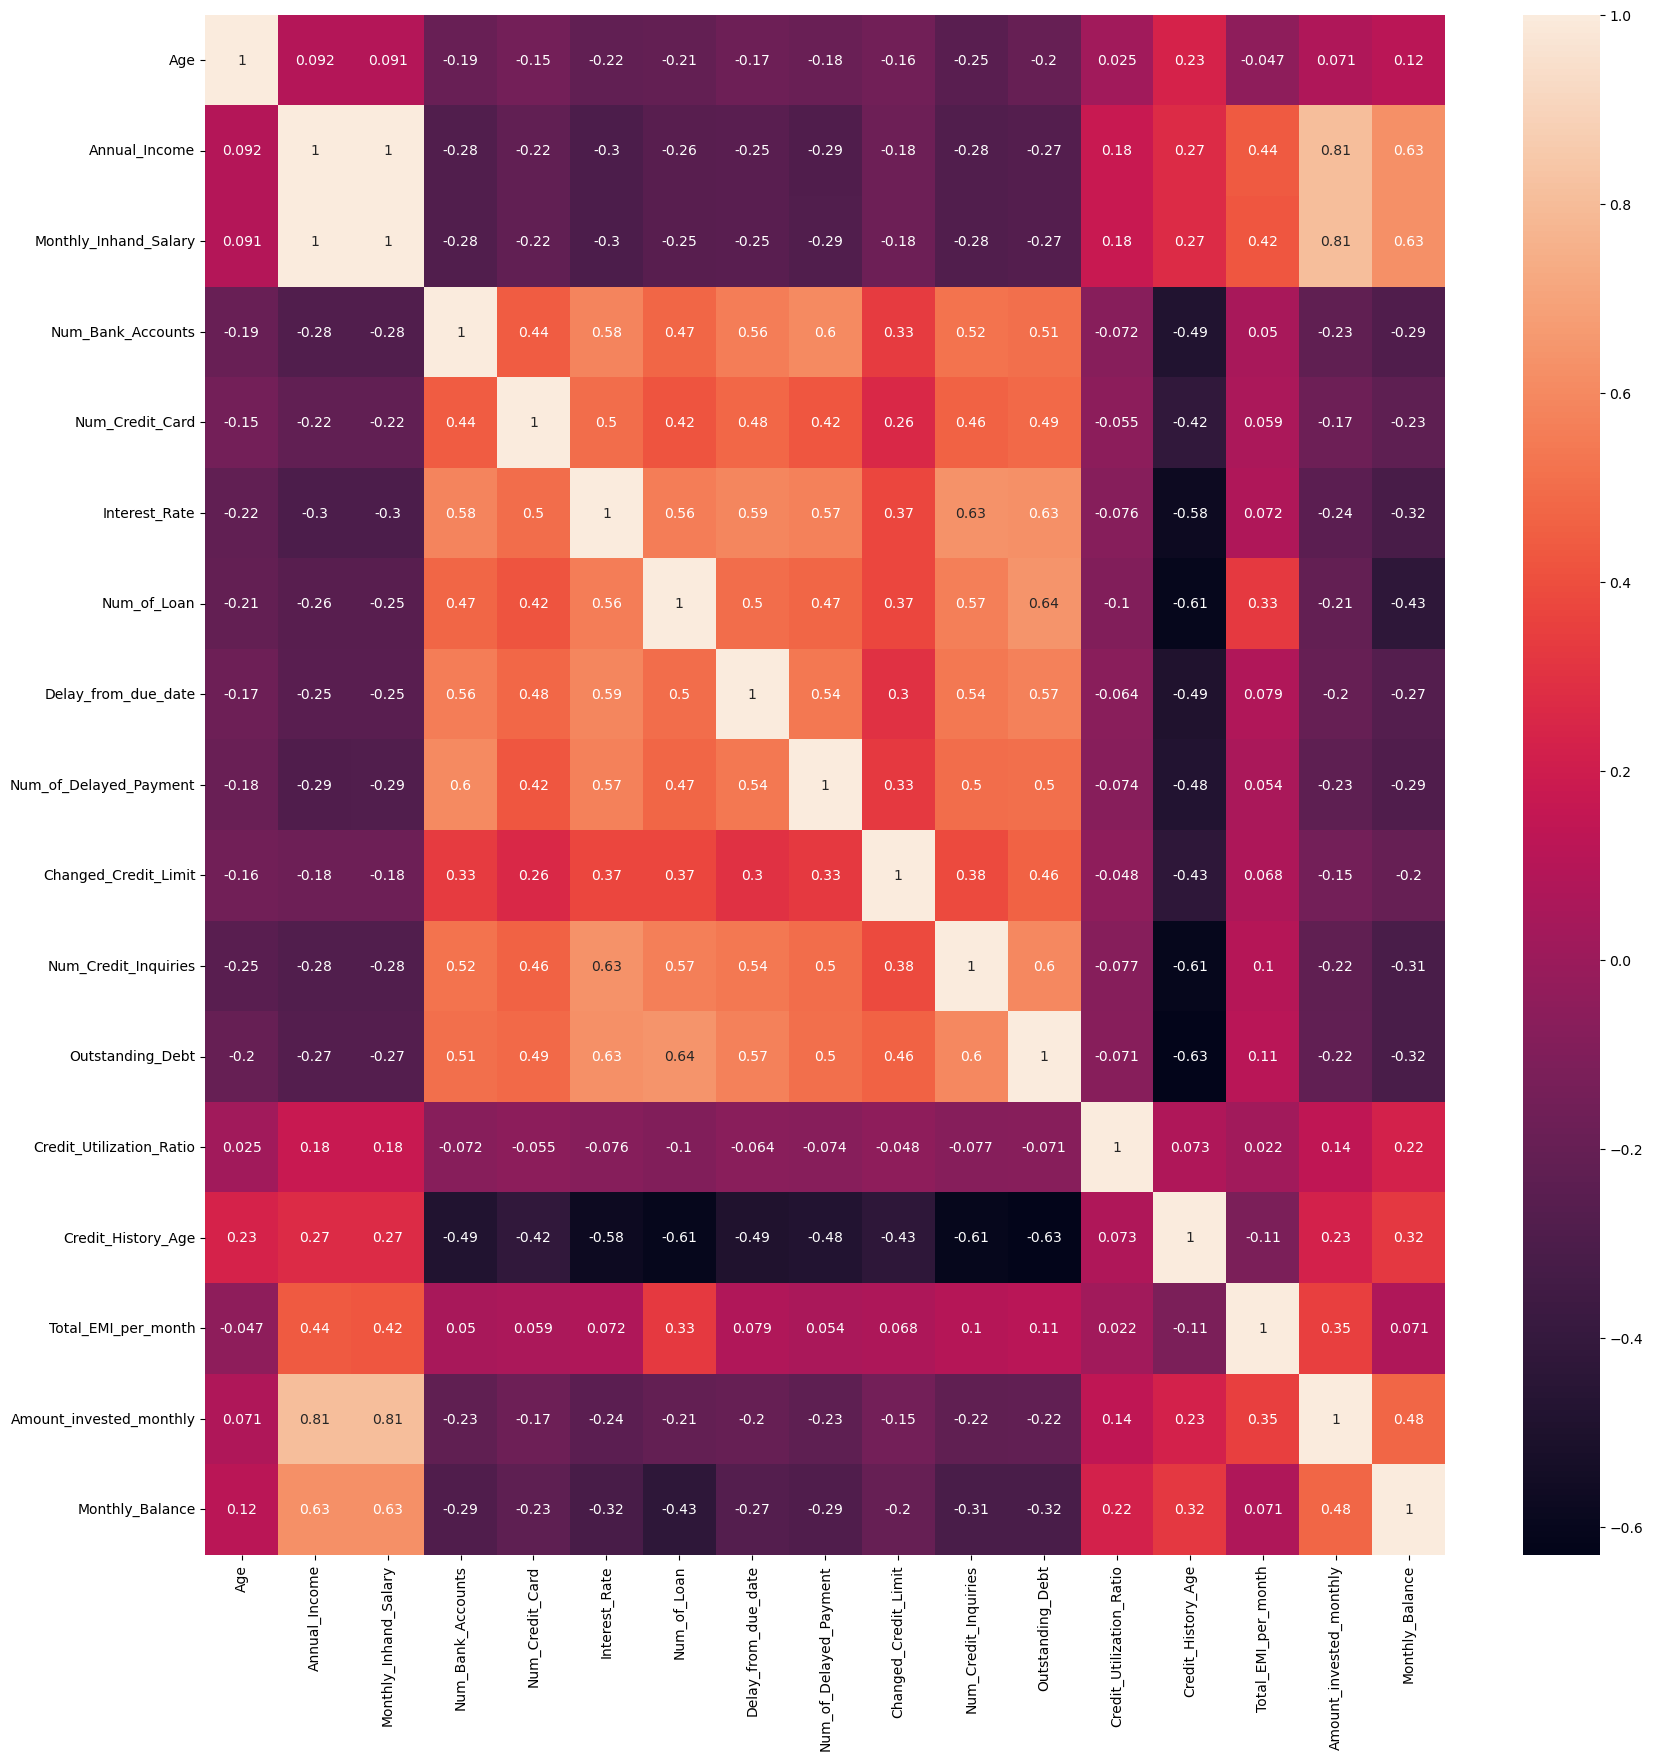

In [13]:
relations = numeric_cols.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data=relations, annot=True)

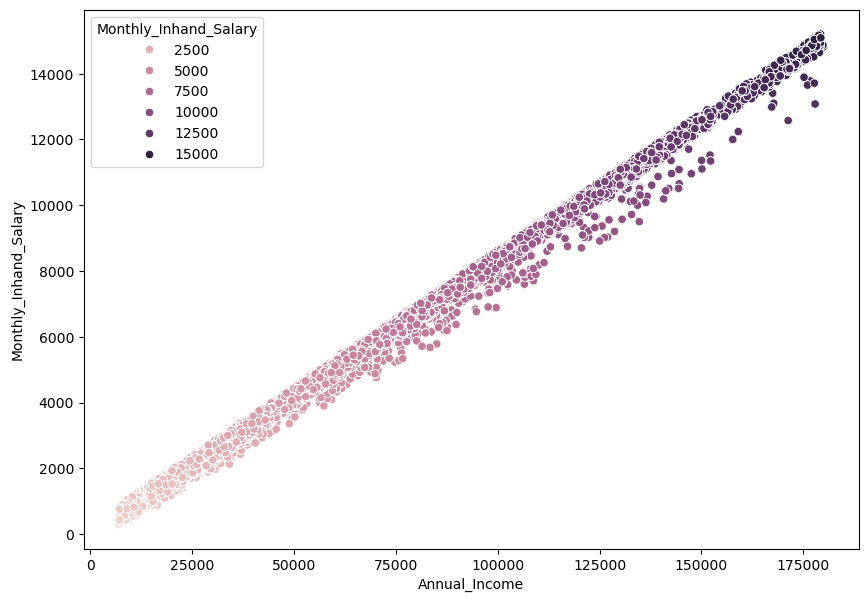

In [14]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="Annual_Income", y="Monthly_Inhand_Salary", hue="Monthly_Inhand_Salary")
plt.show()

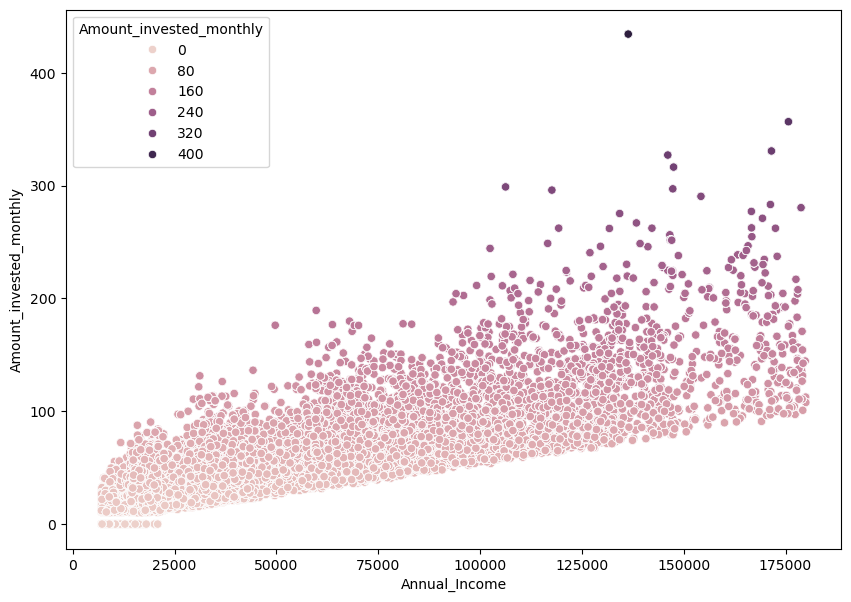

In [15]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="Annual_Income", y="Amount_invested_monthly", hue="Amount_invested_monthly")
plt.show()

# Histogram Visuals

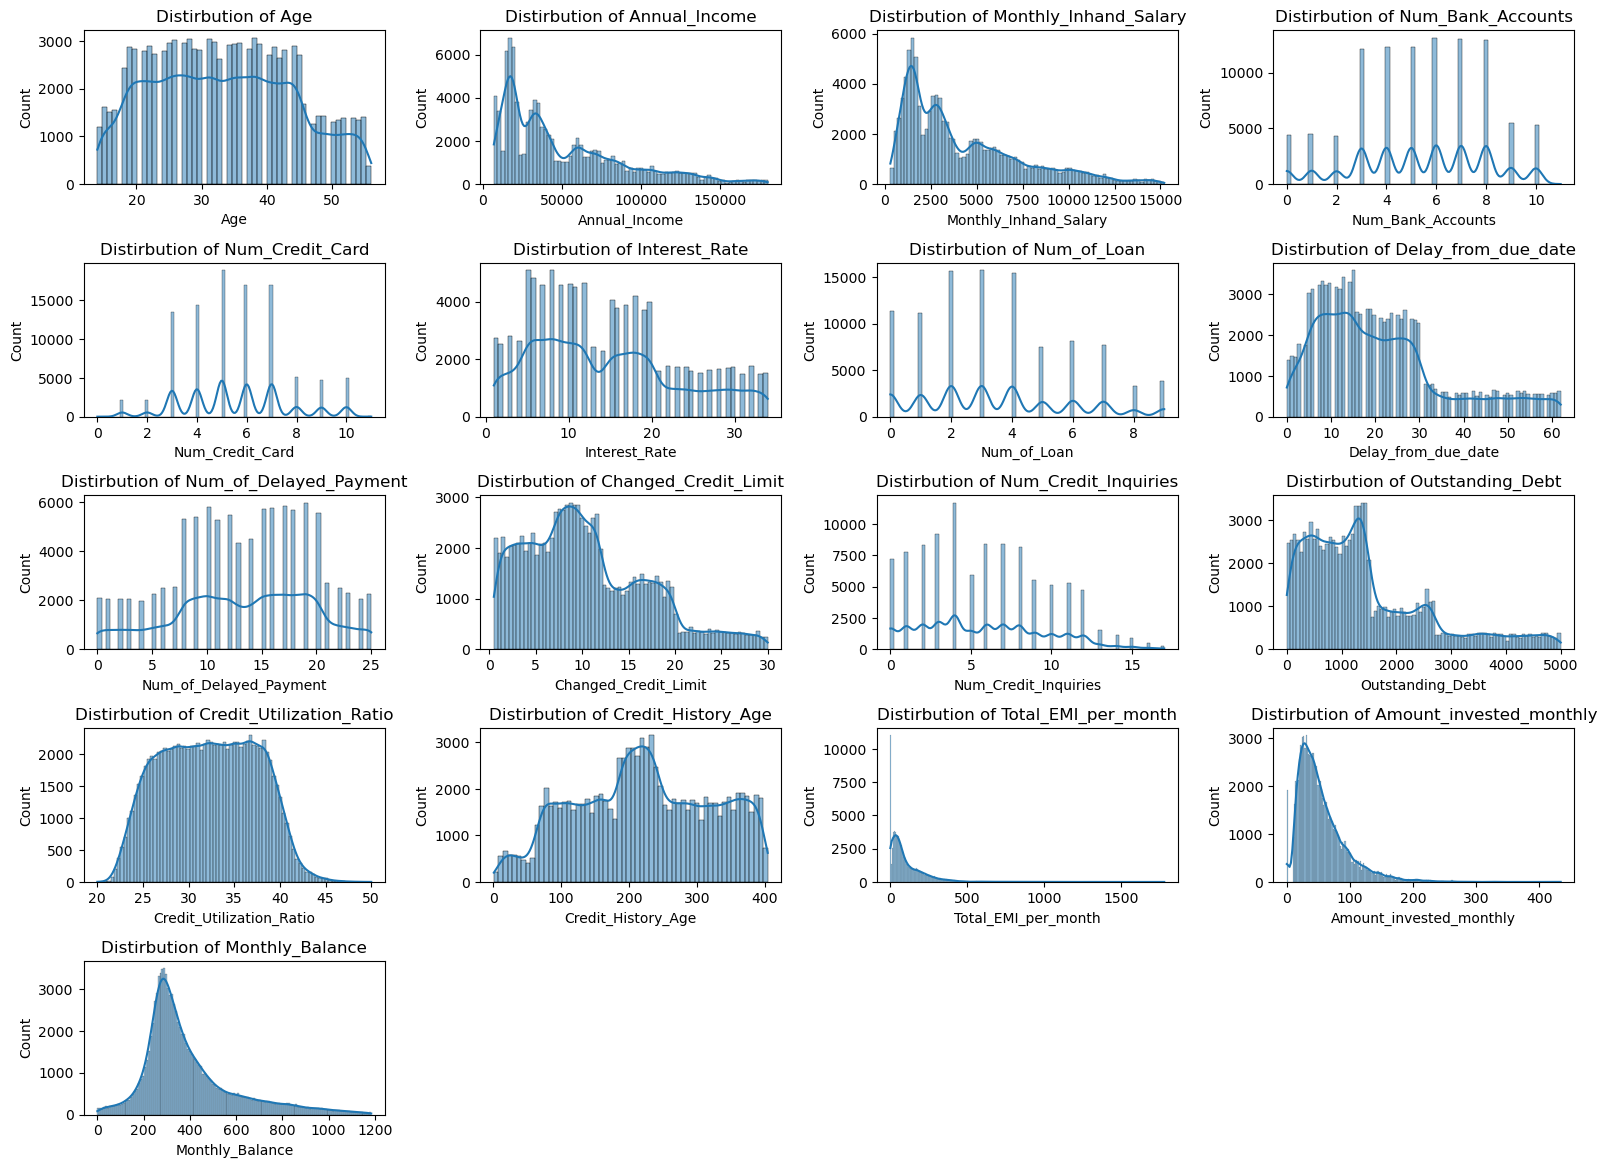

In [16]:
plot_distribution(numeric_cols, "hist")

# Box Plot

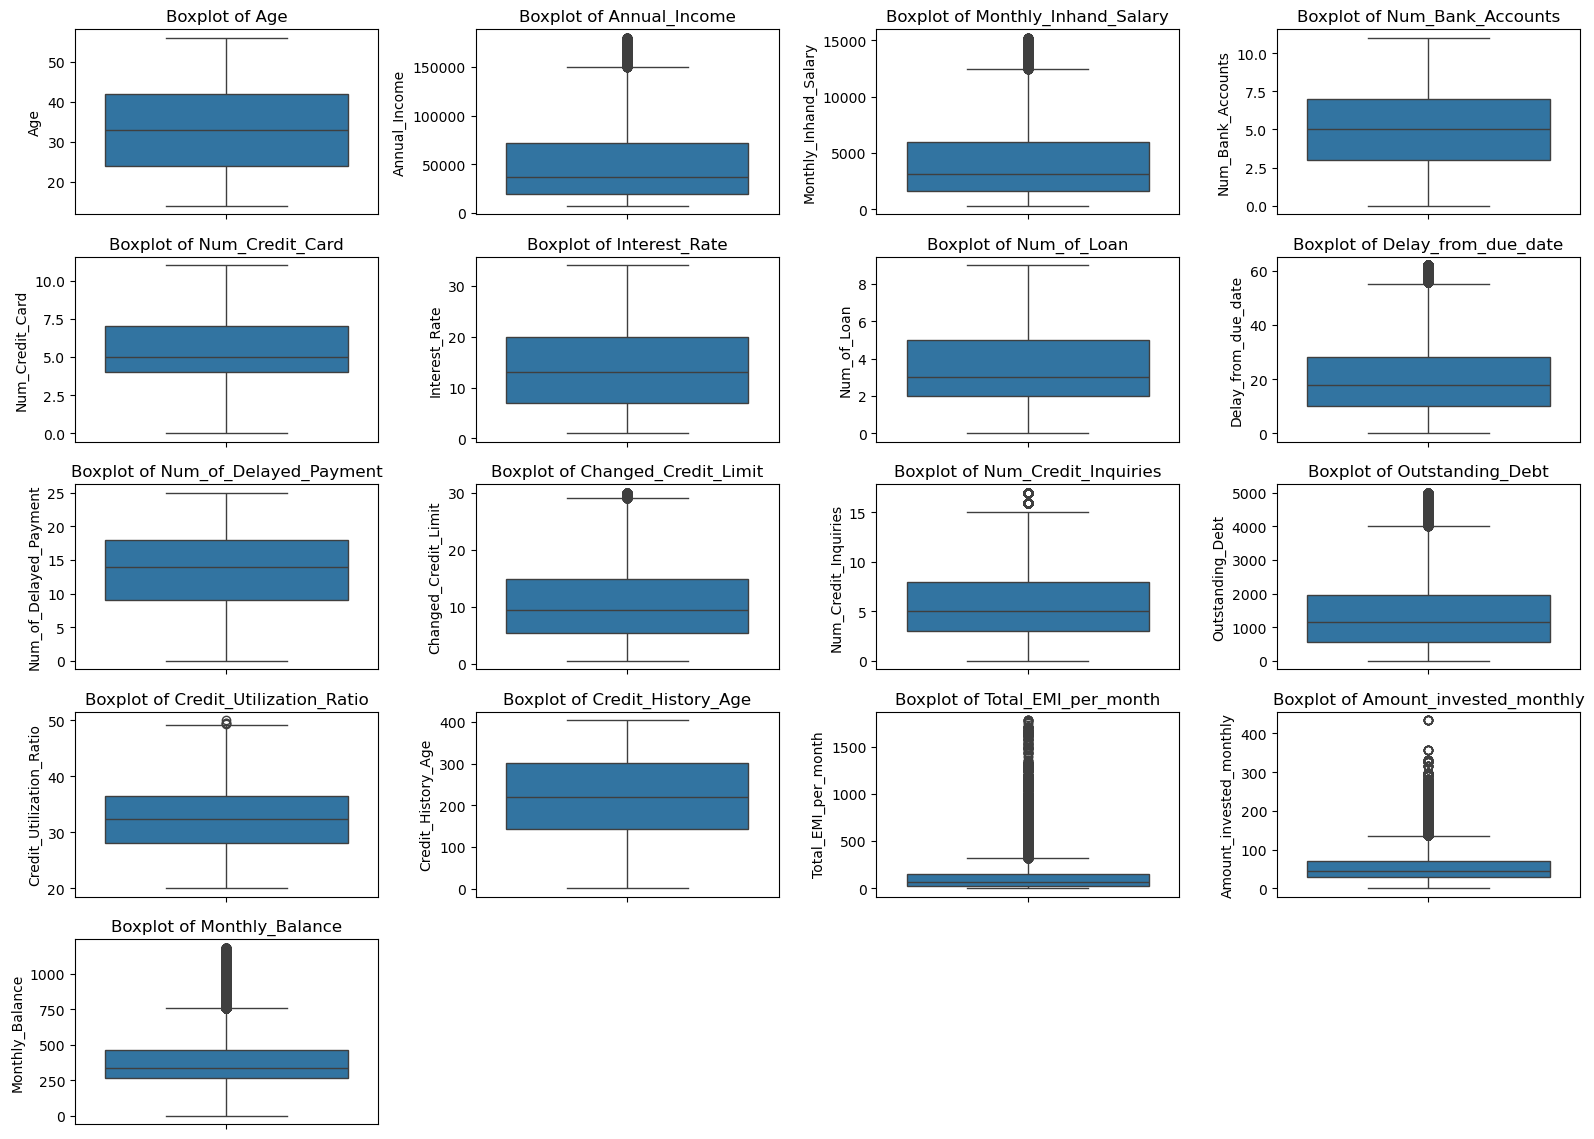

In [17]:
plot_distribution(numeric_cols, "boxplot")

# Data Follows A Power Law Dist

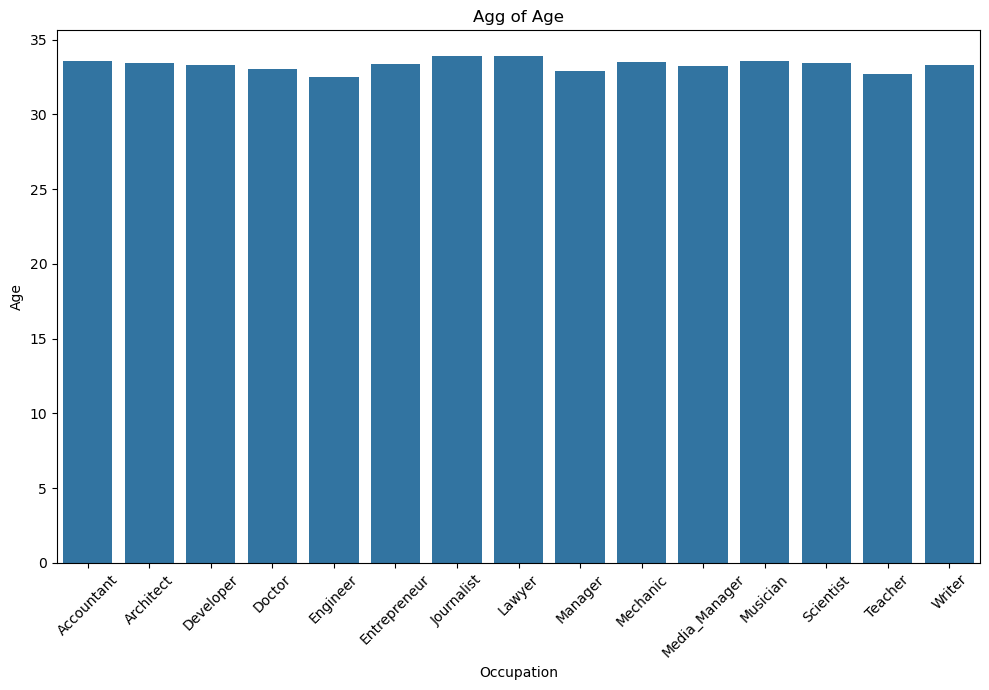

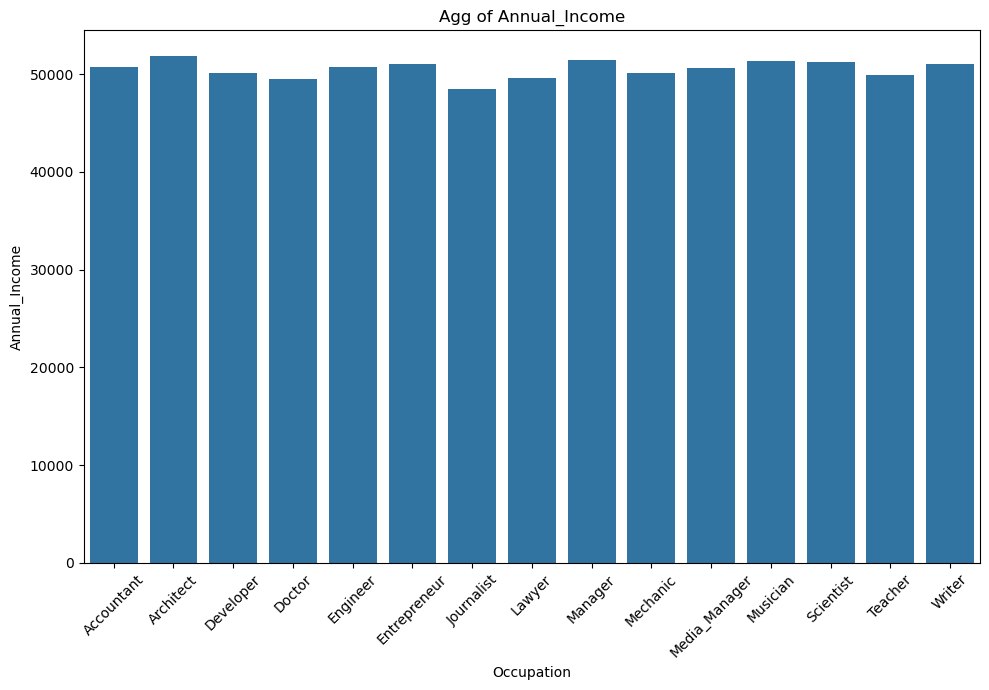

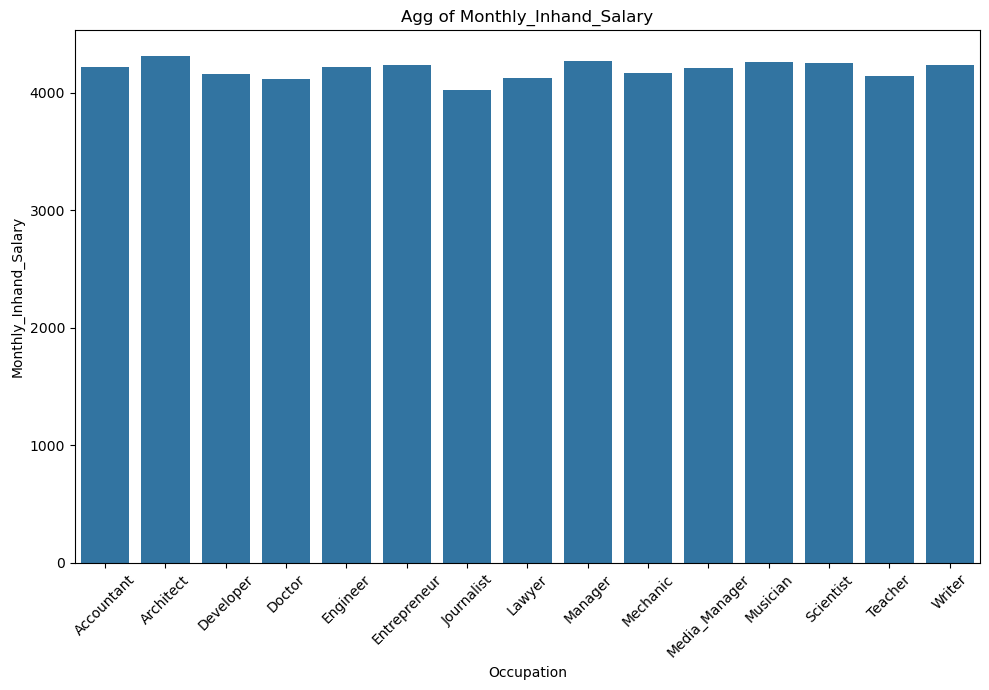

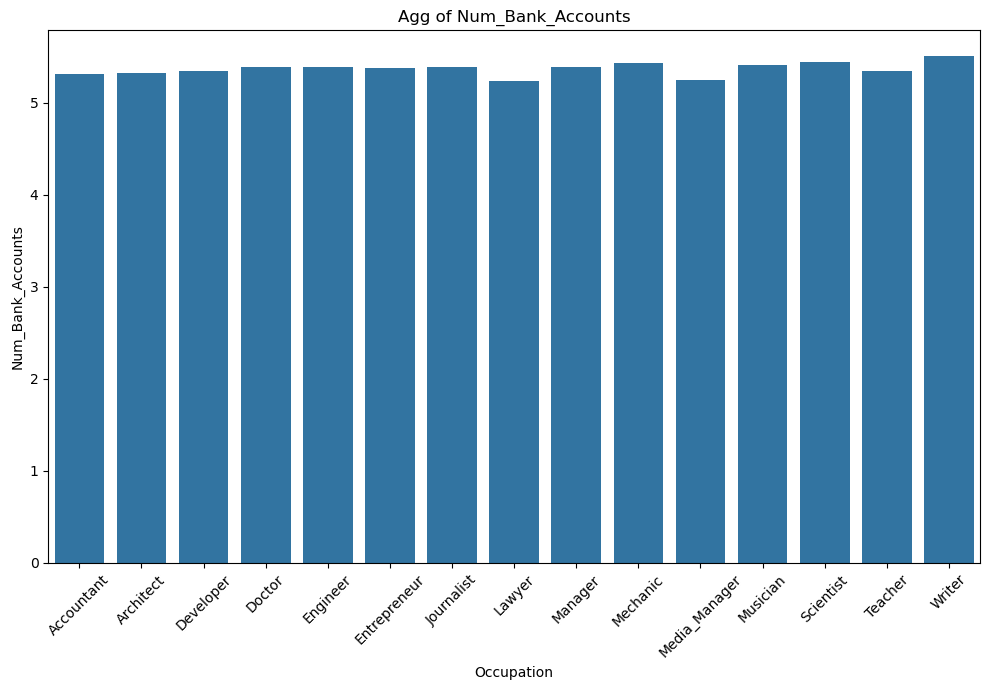

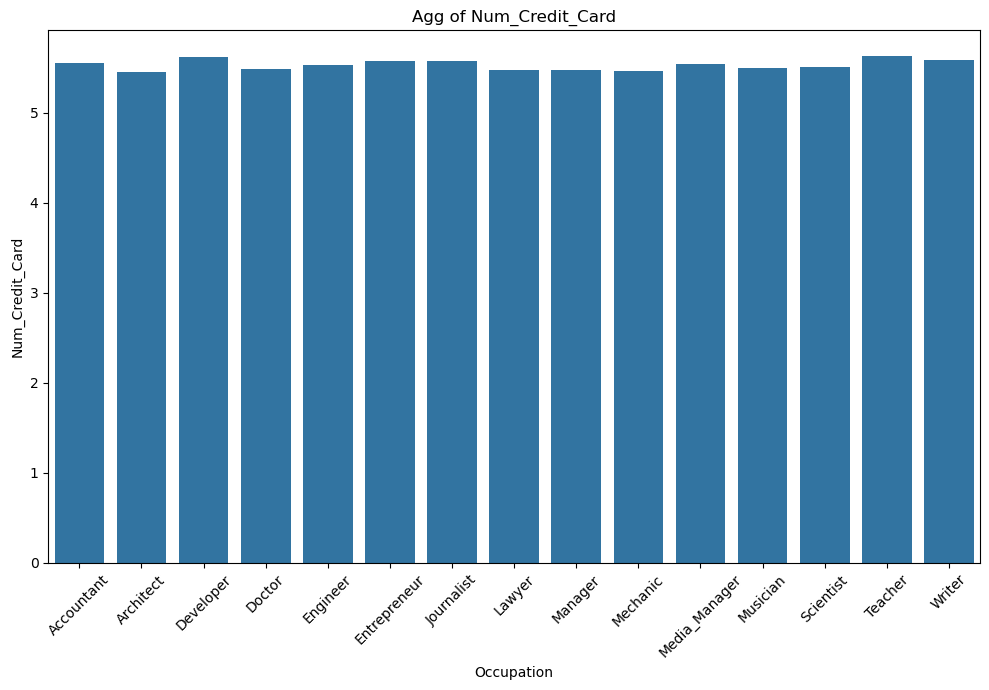

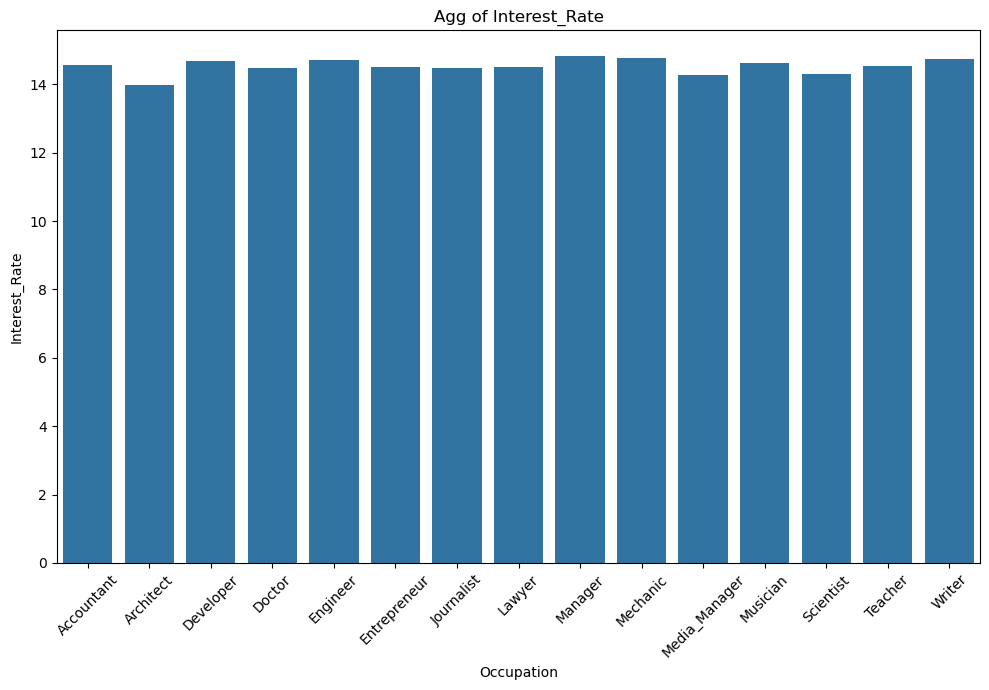

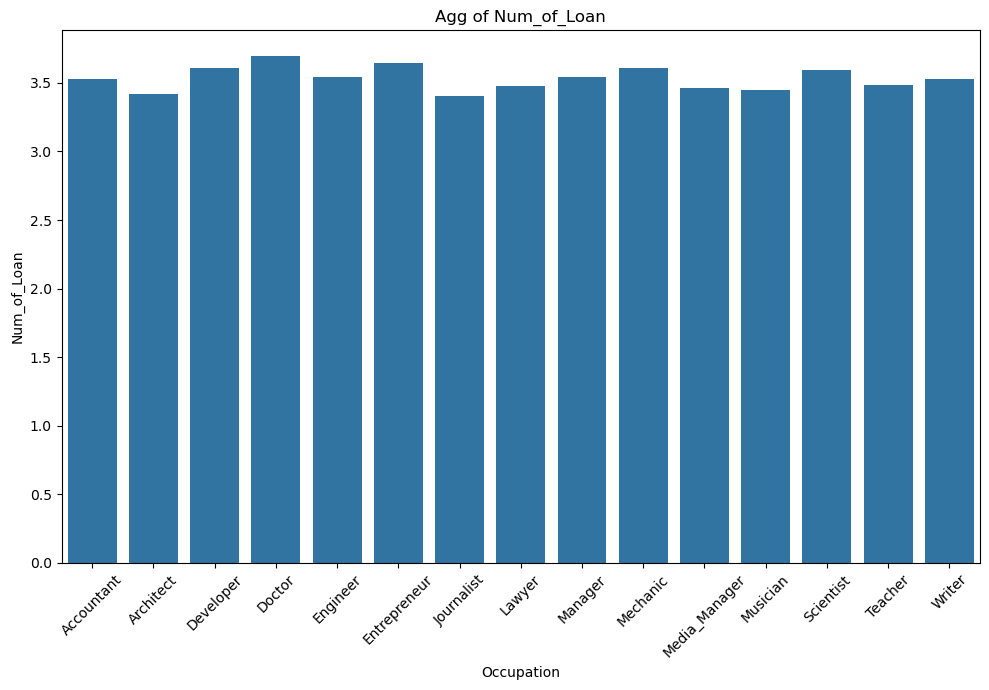

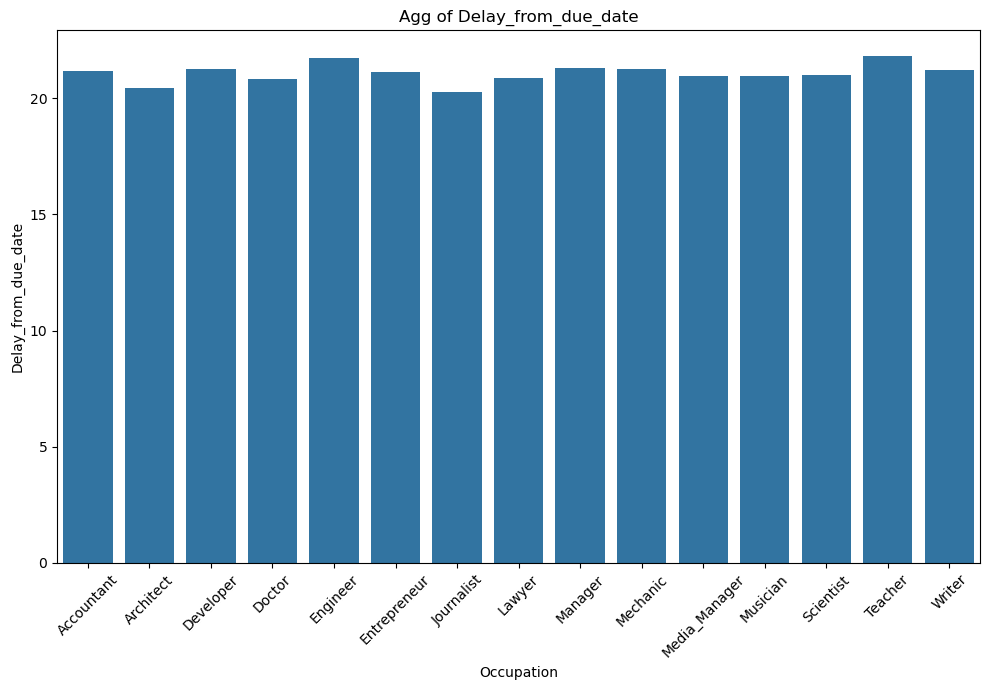

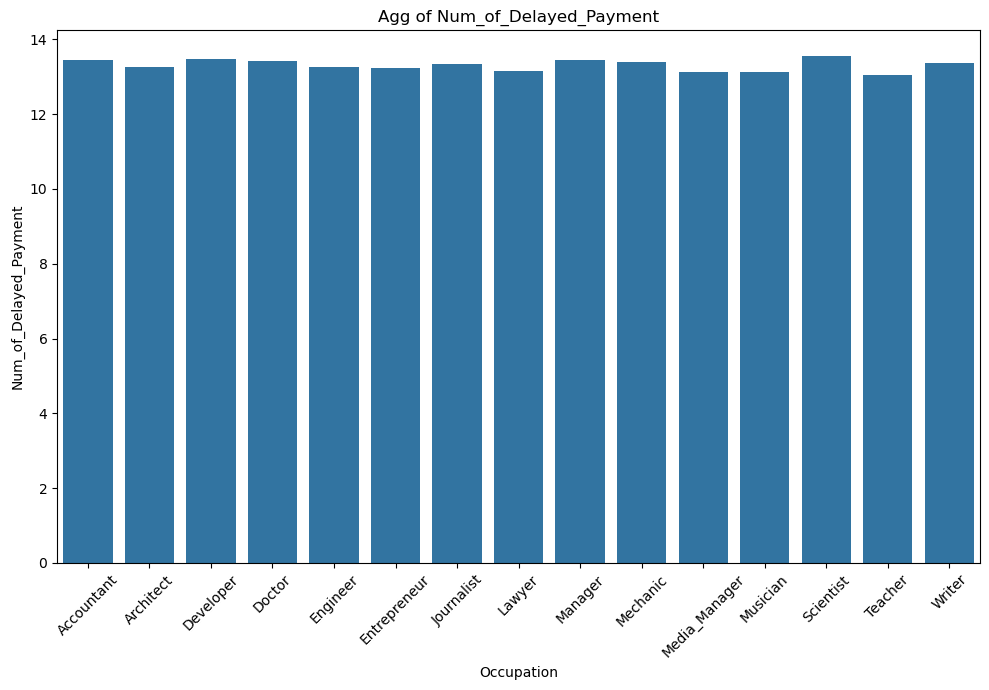

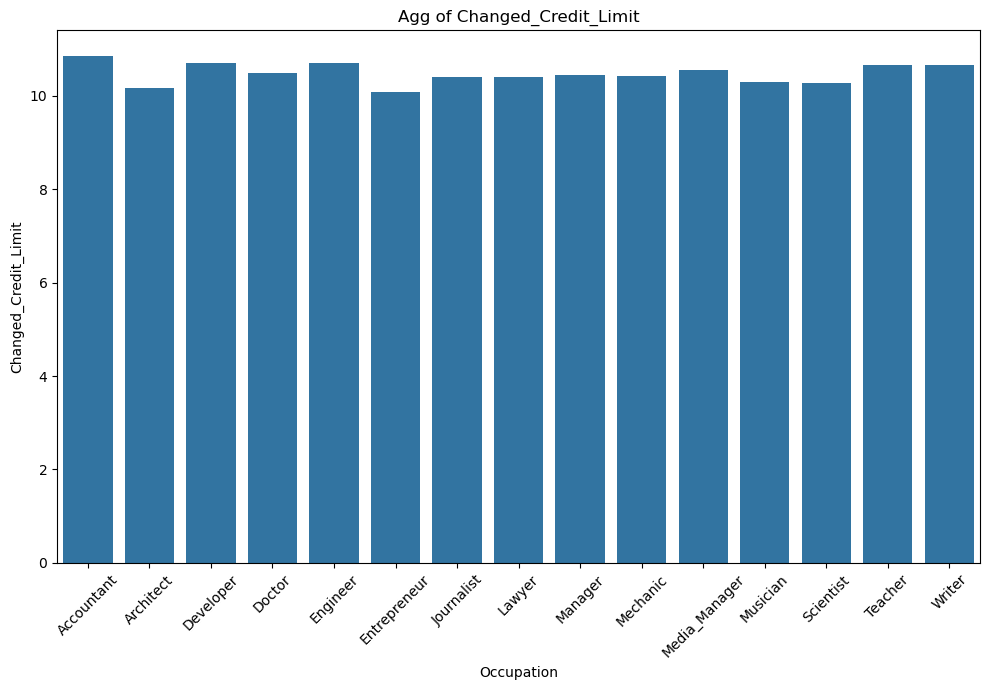

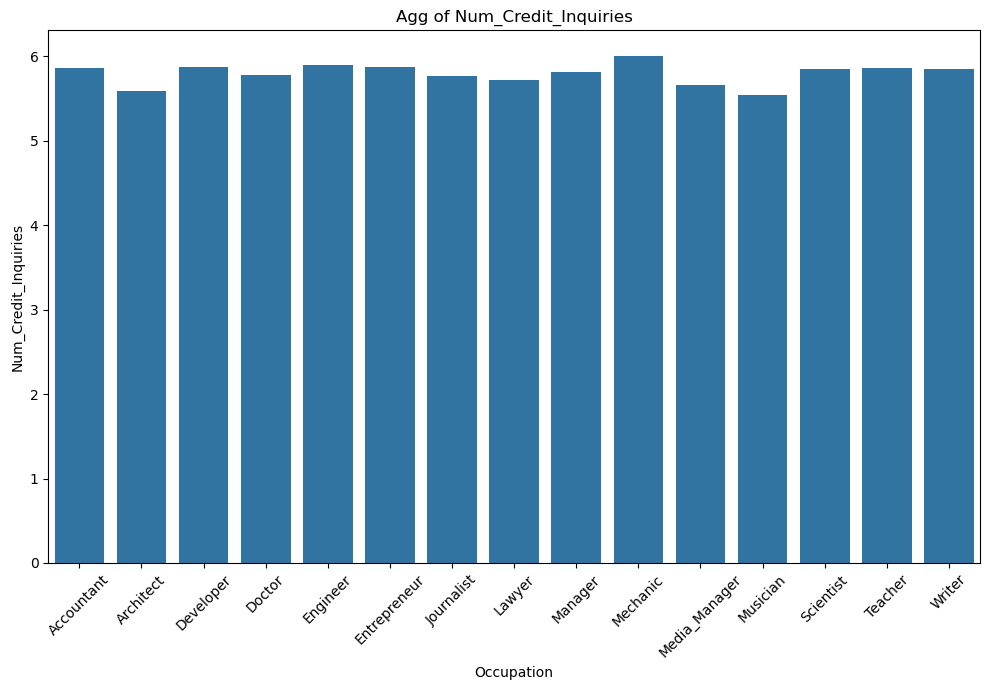

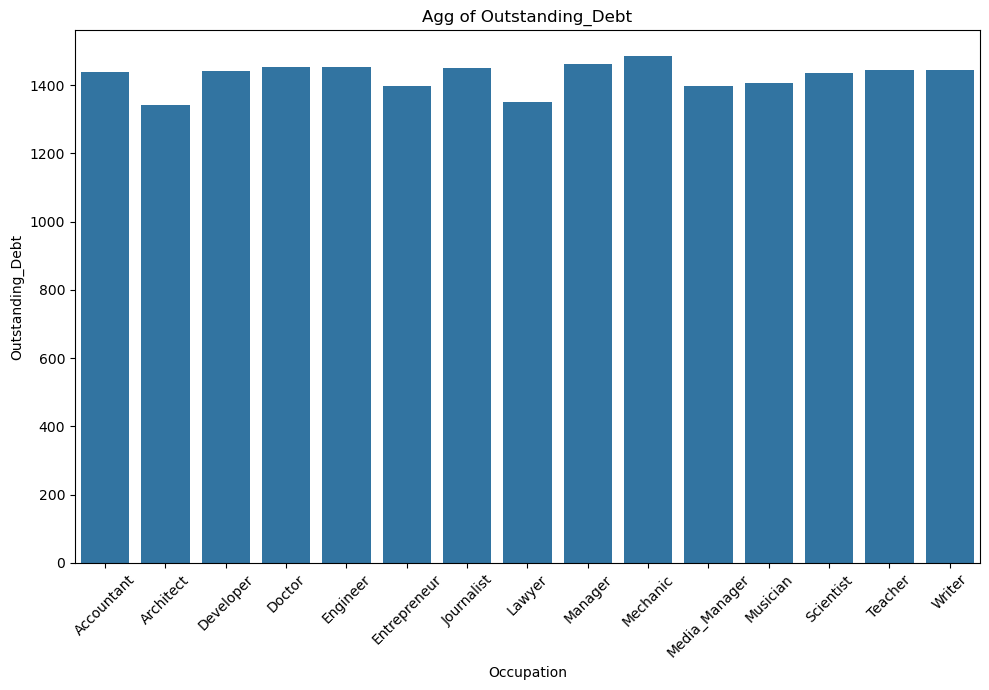

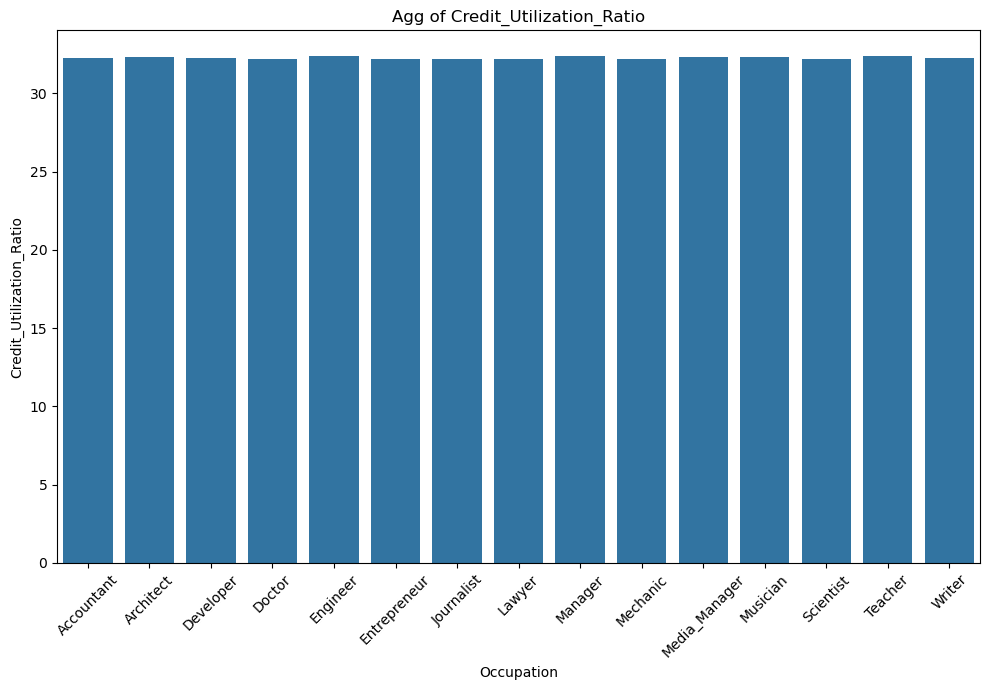

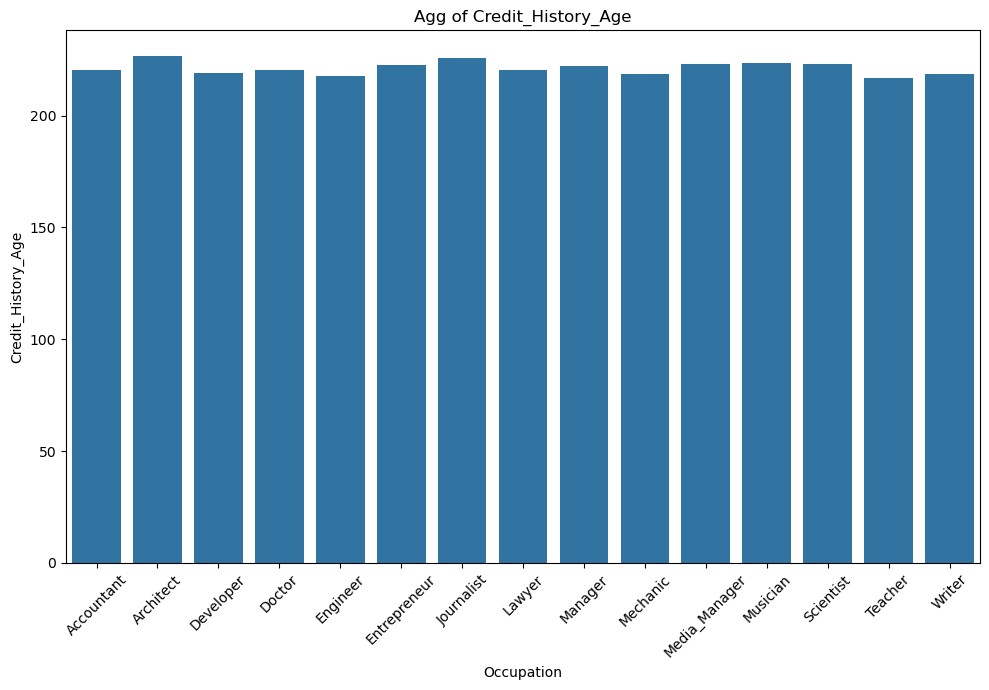

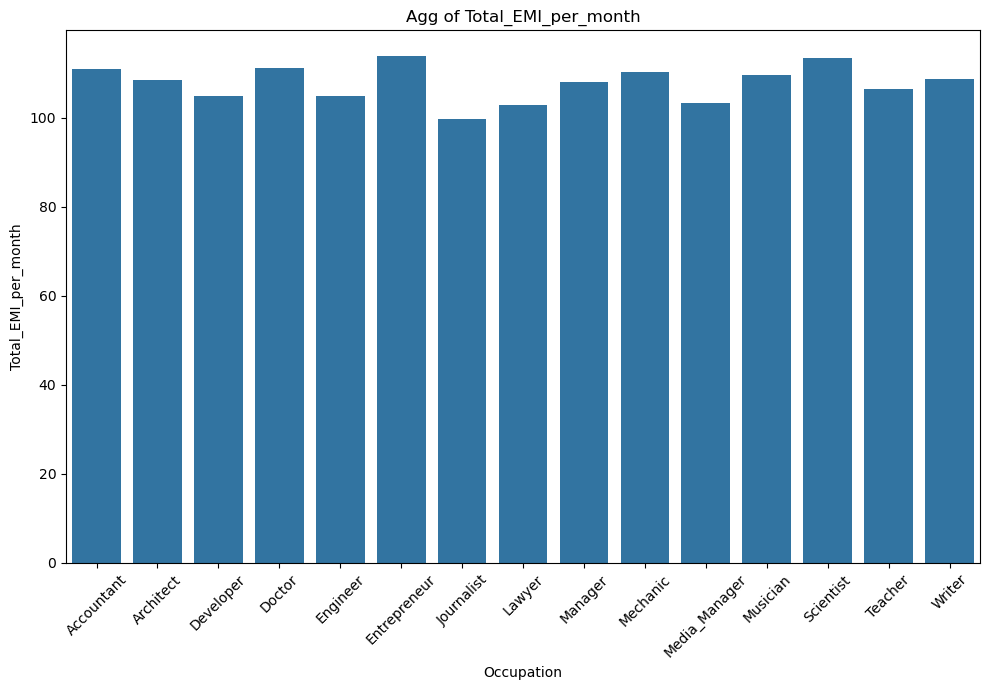

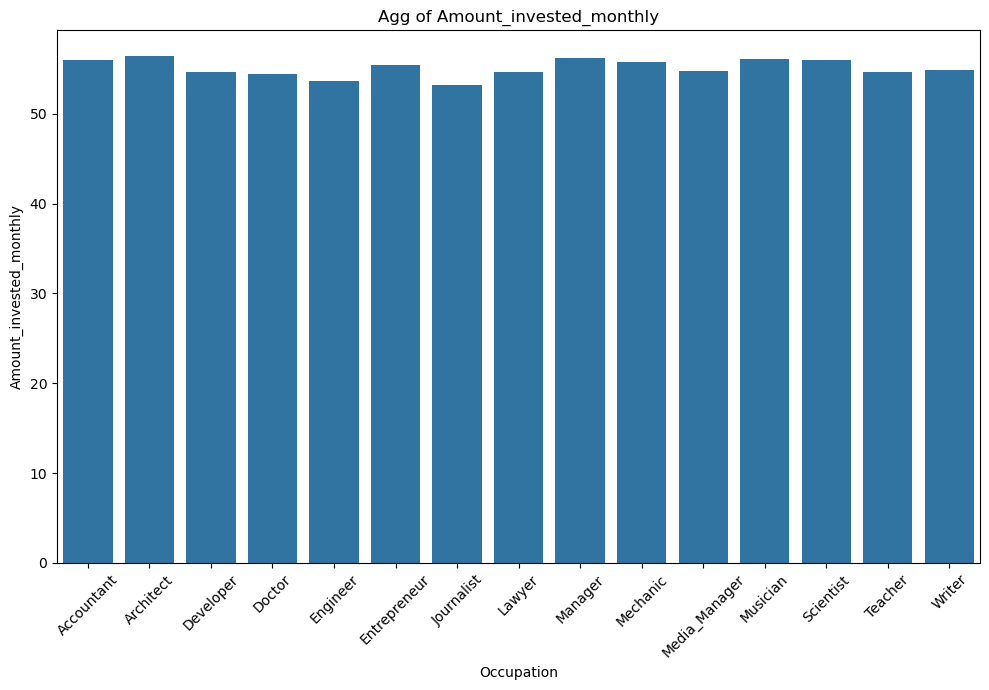

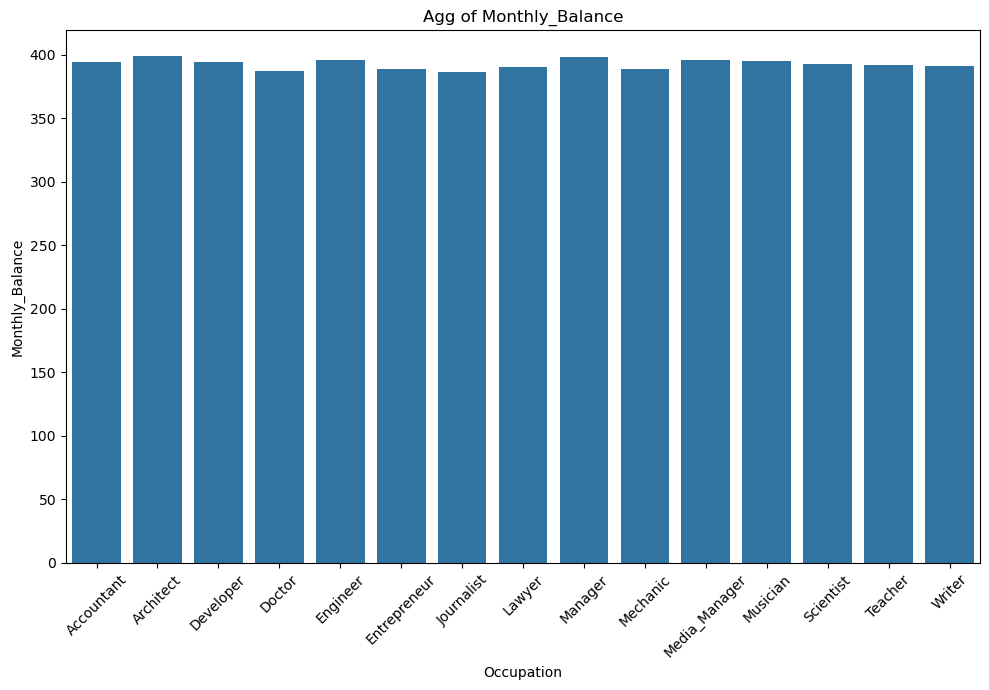

In [18]:
for col in numeric_cols.columns:
  aggregate_dataset(df, "Occupation", col, "mean")

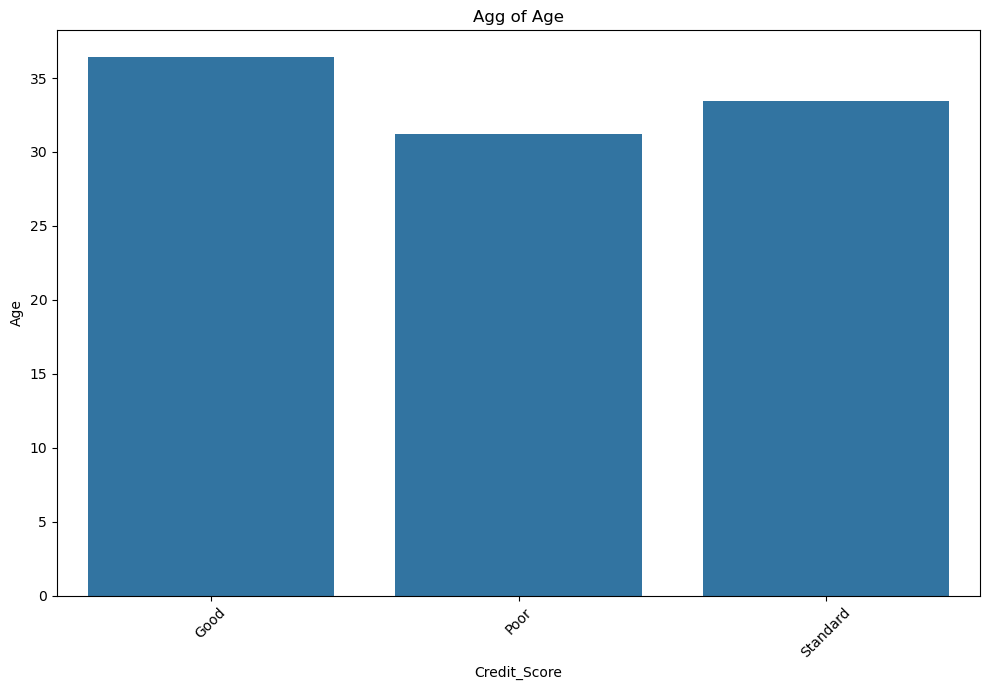

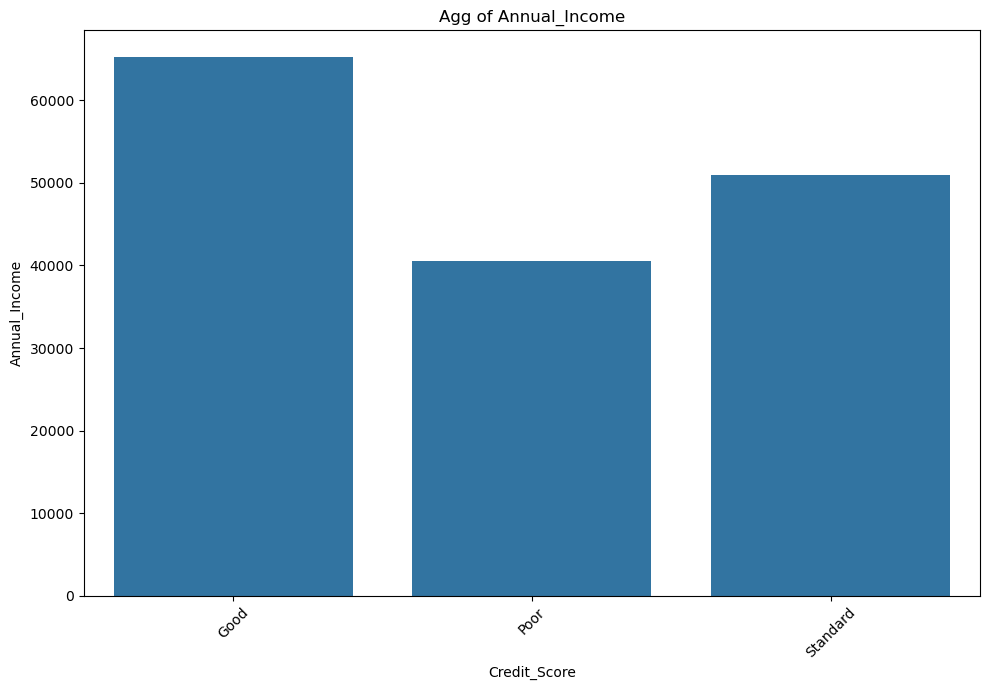

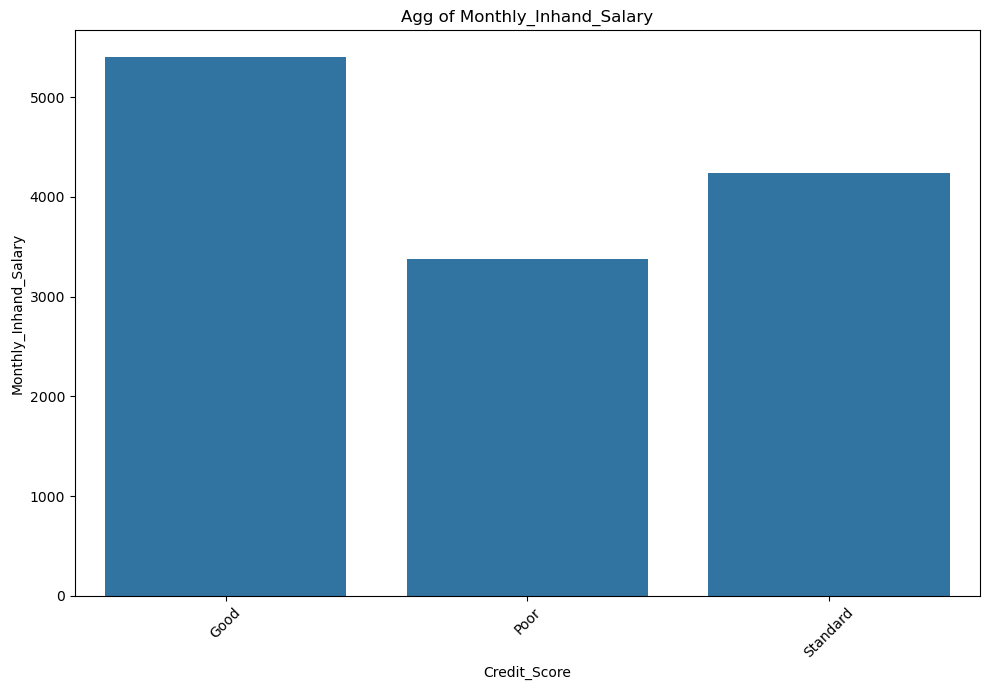

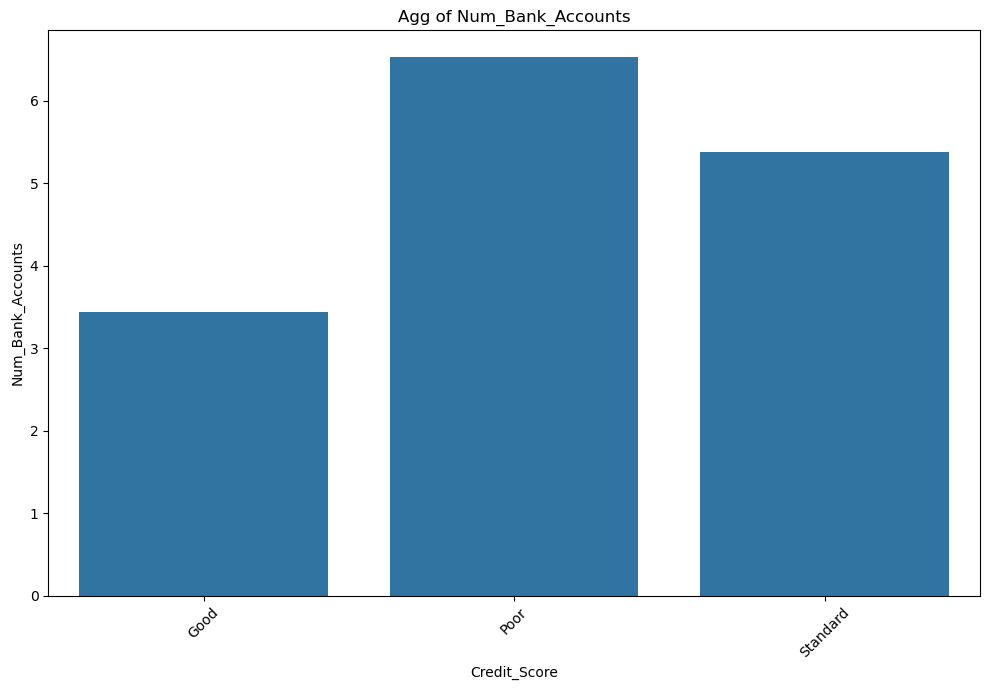

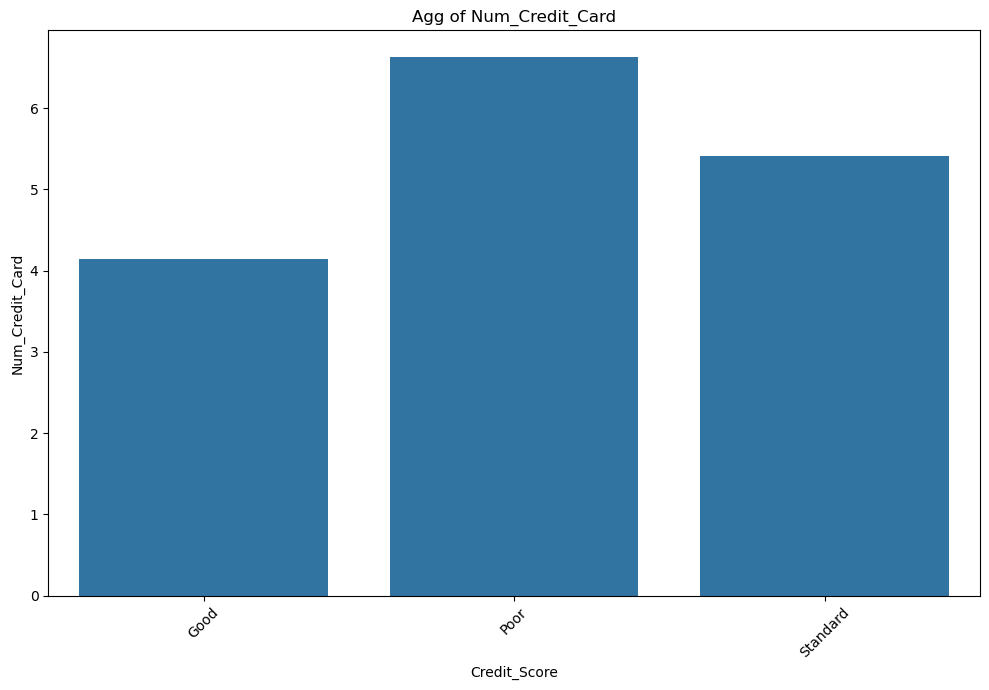

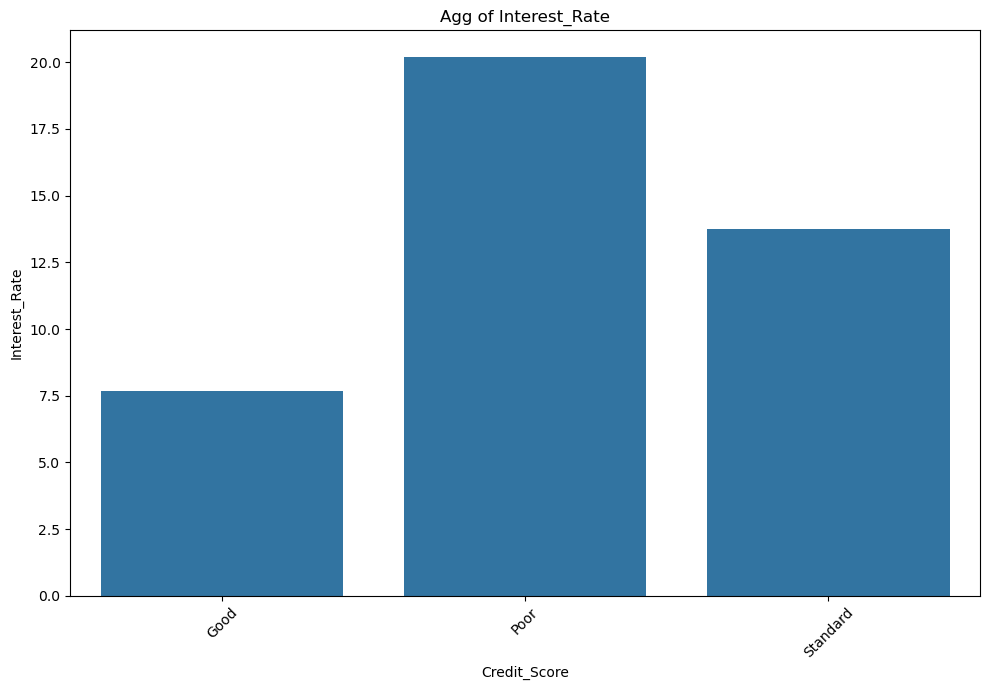

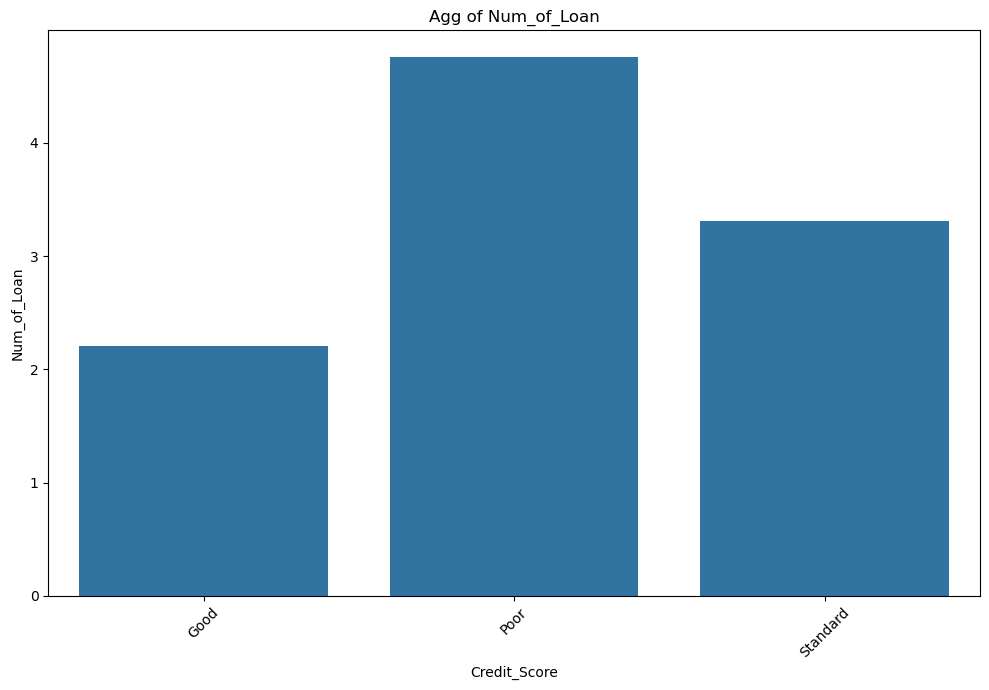

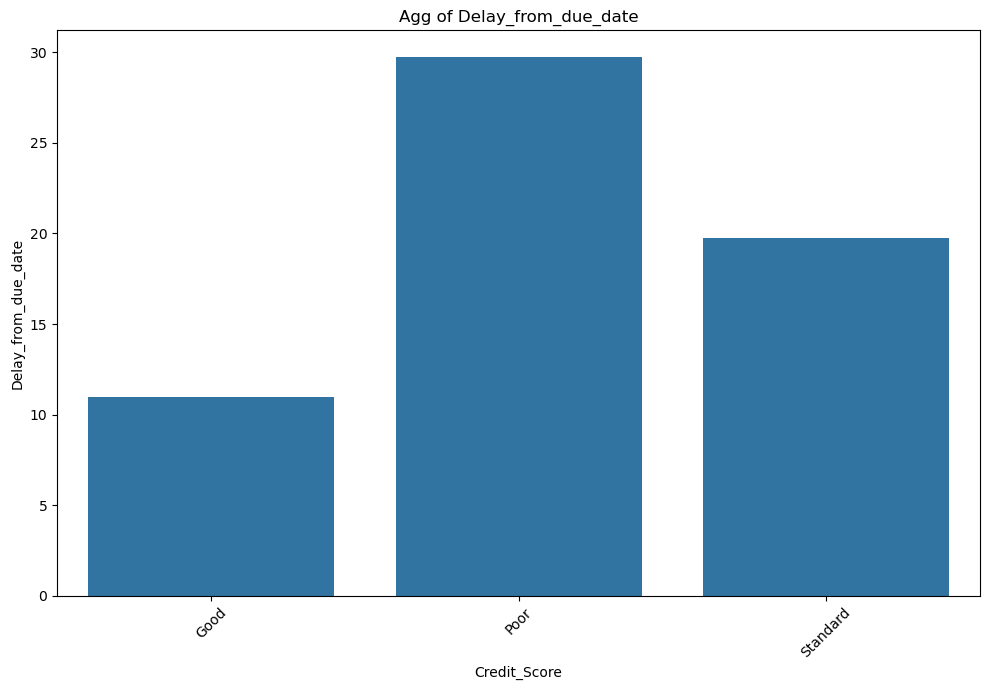

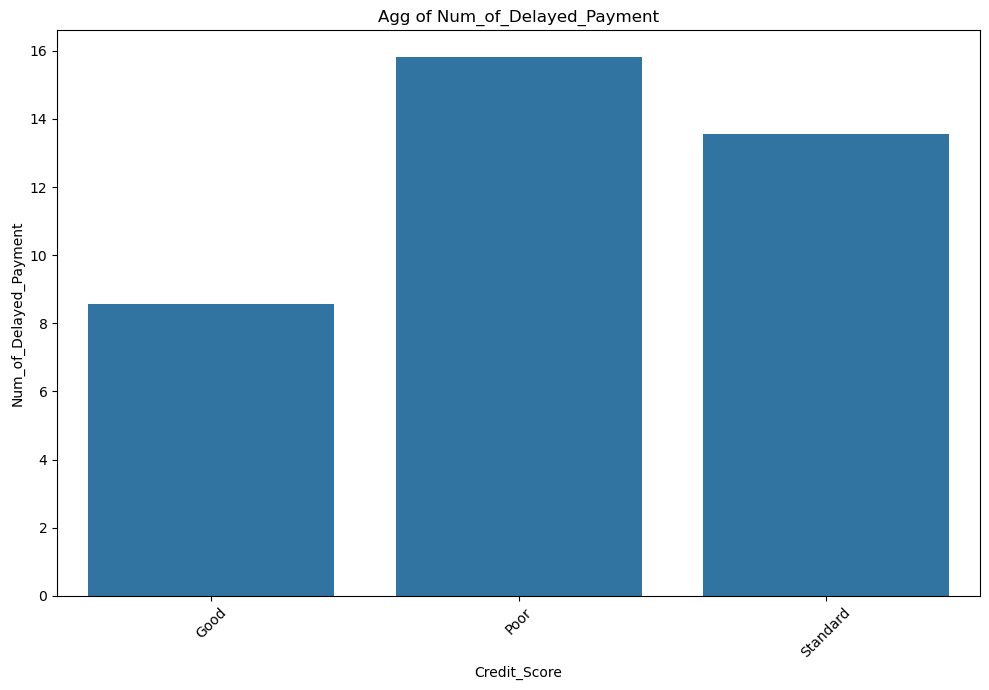

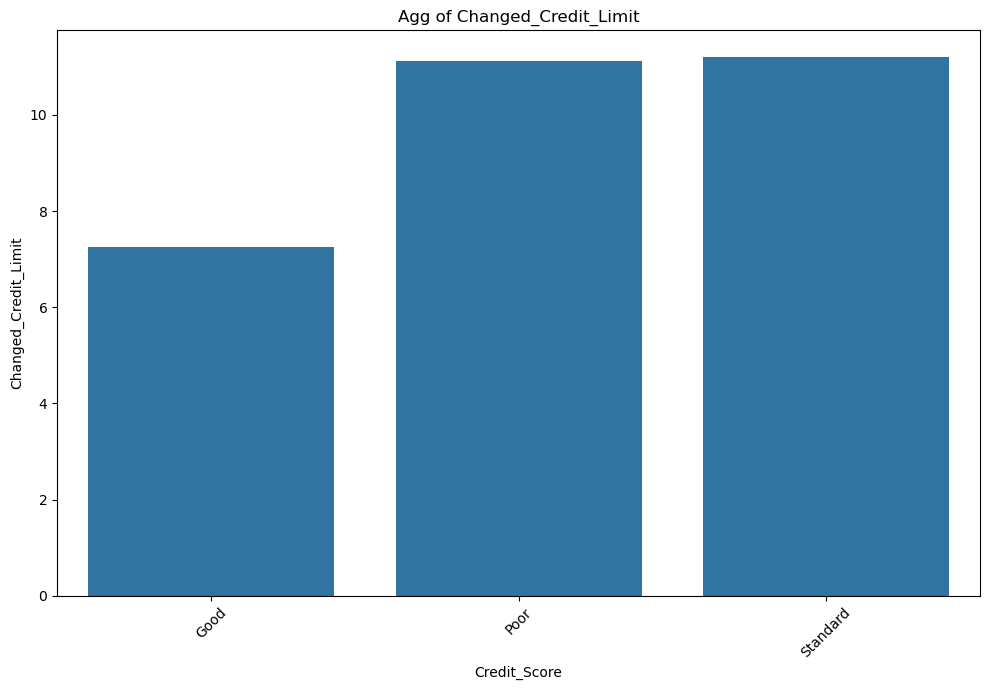

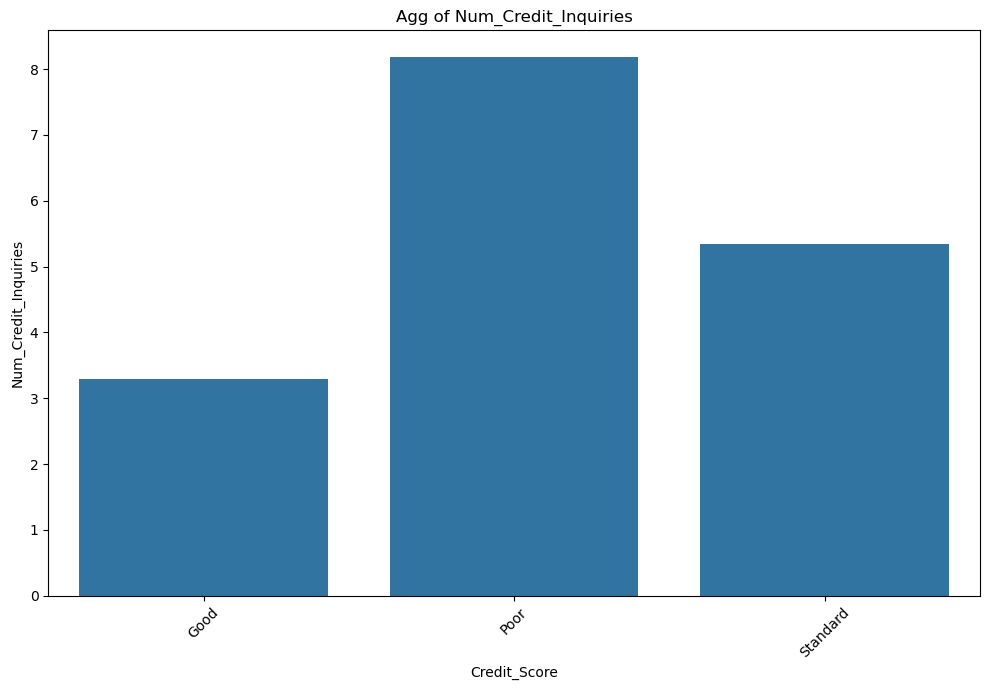

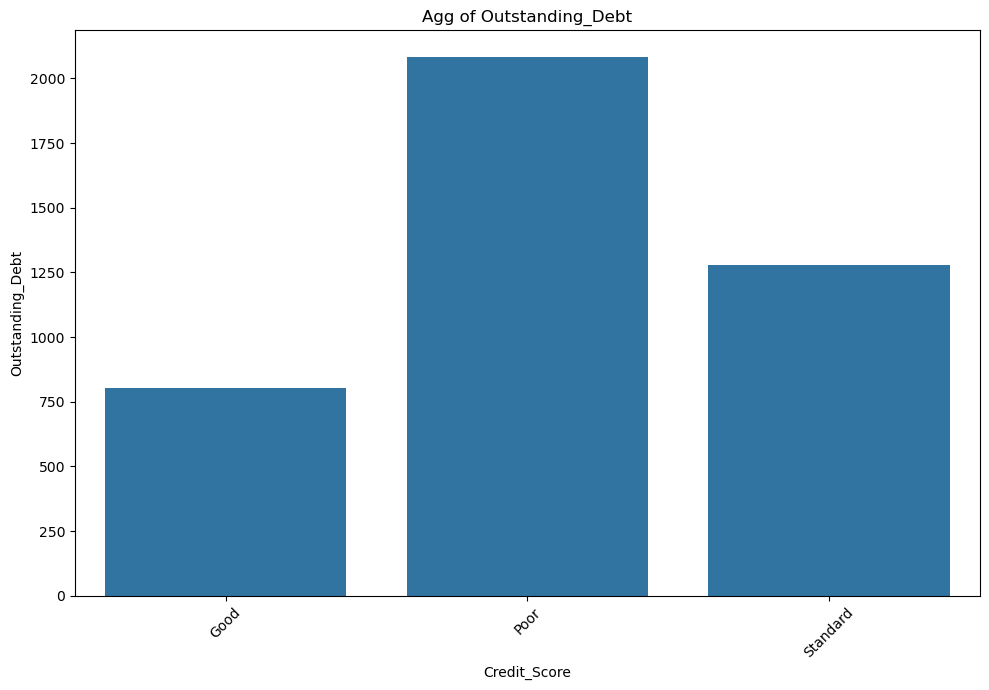

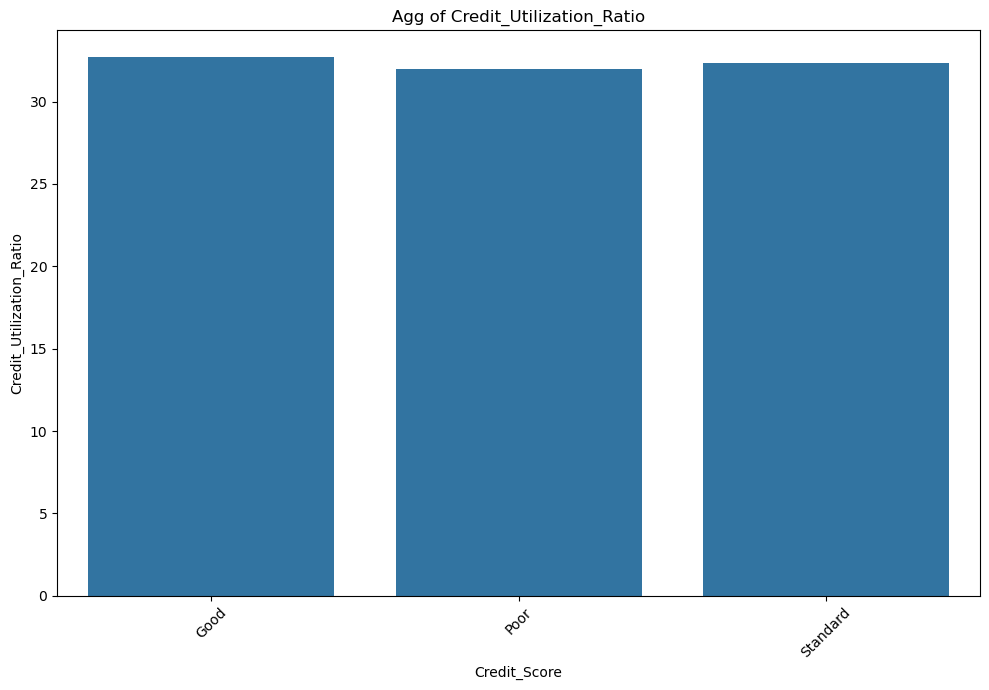

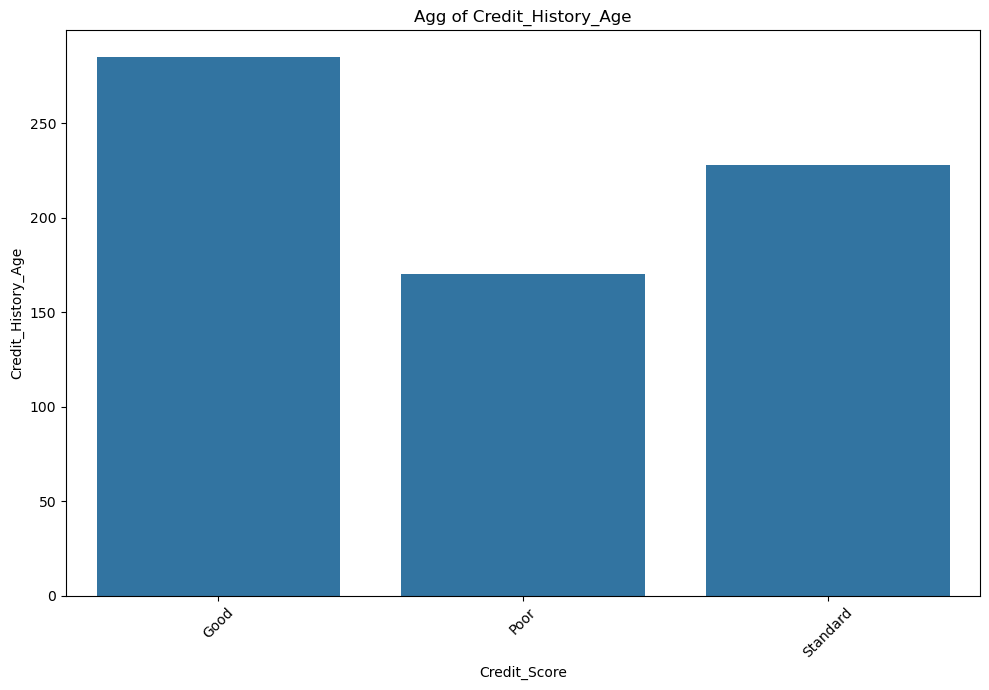

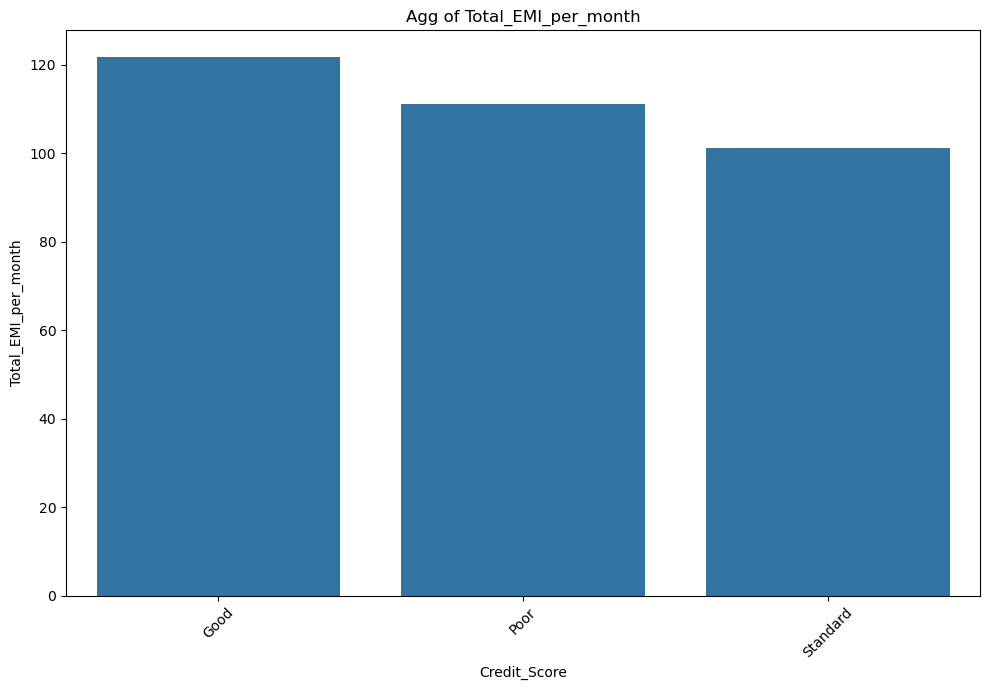

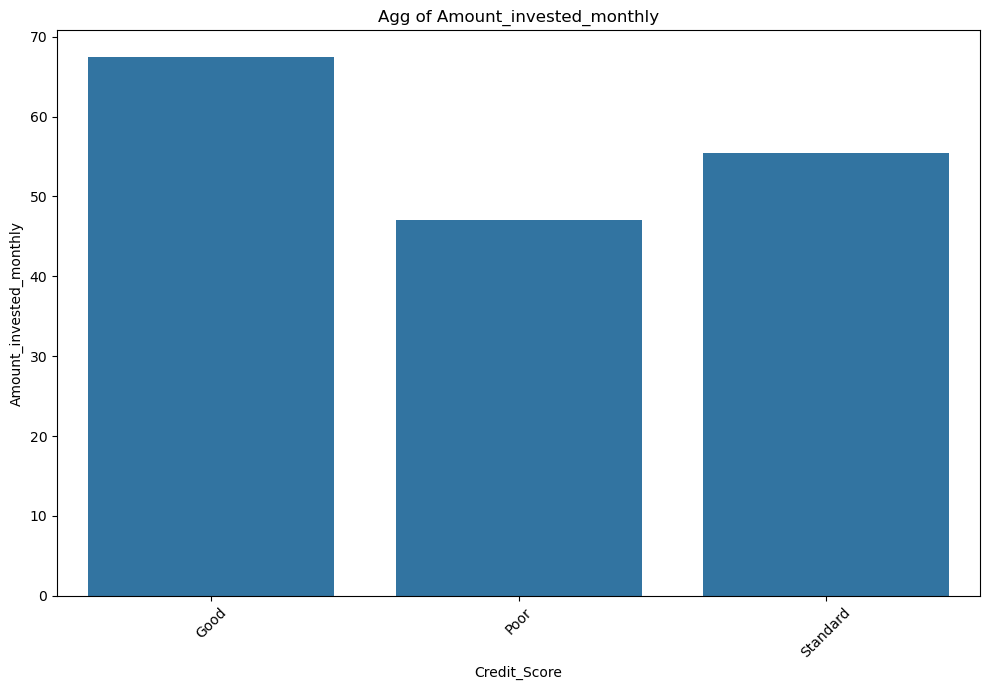

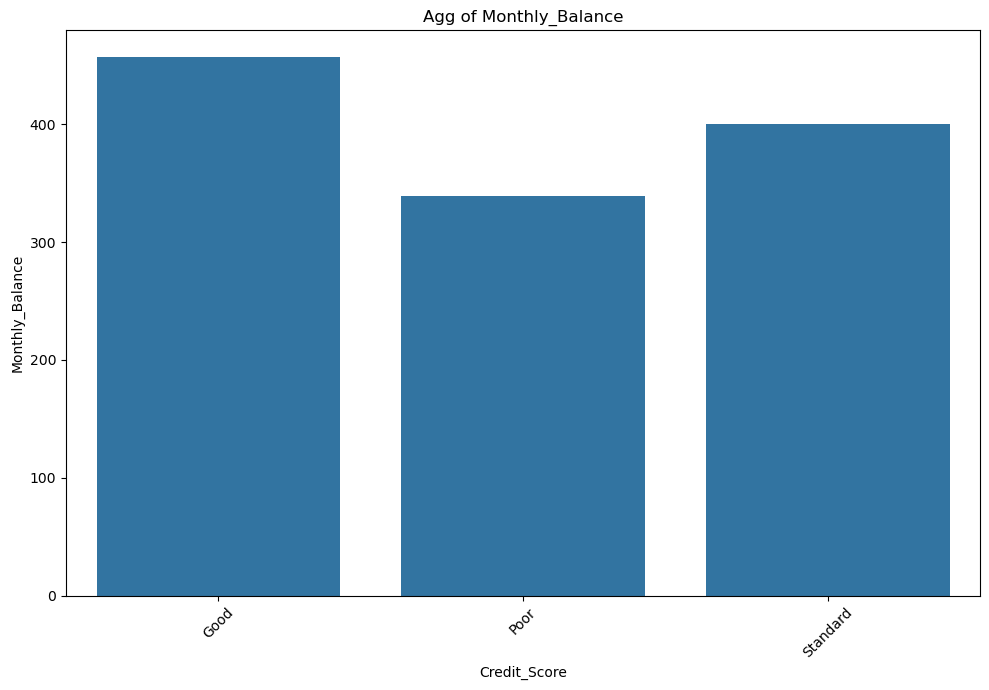

In [19]:
for col in numeric_cols.columns:
  aggregate_dataset(df, "Credit_Score", col, "mean")

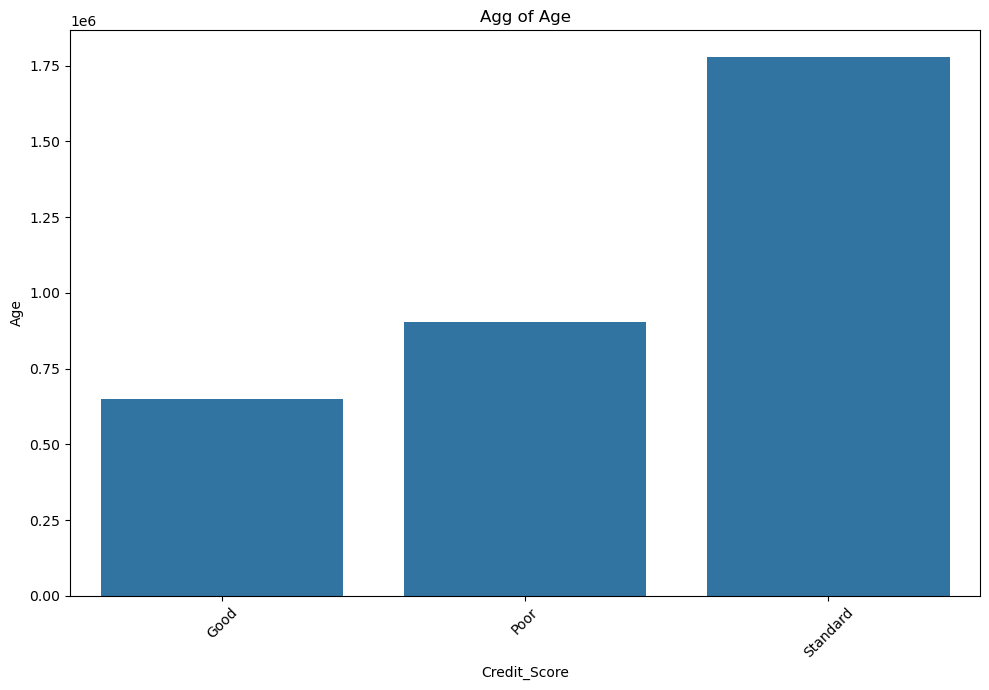

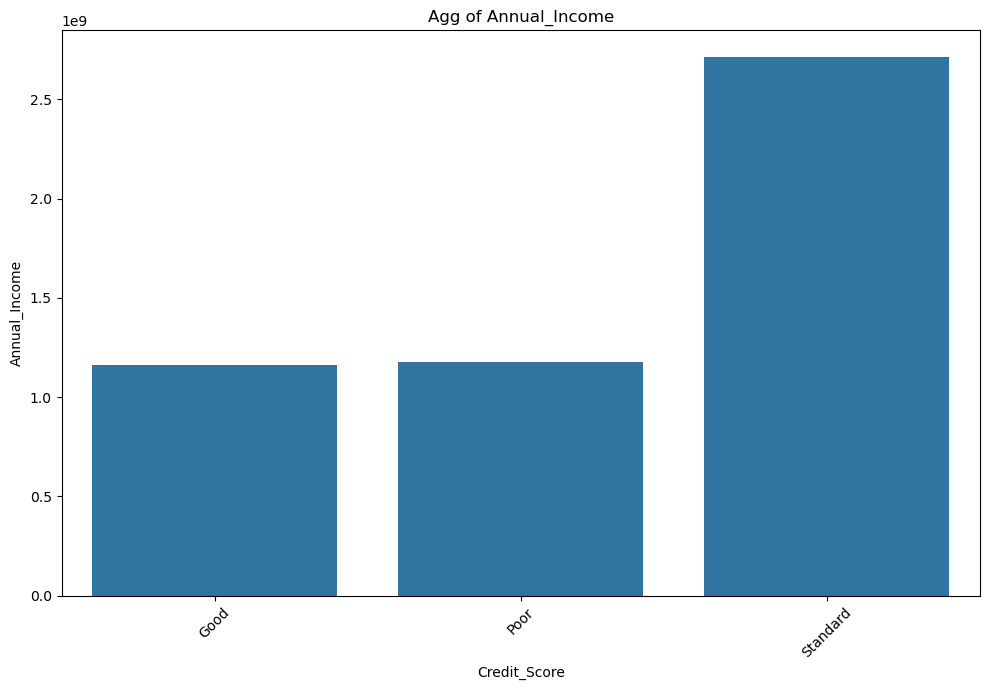

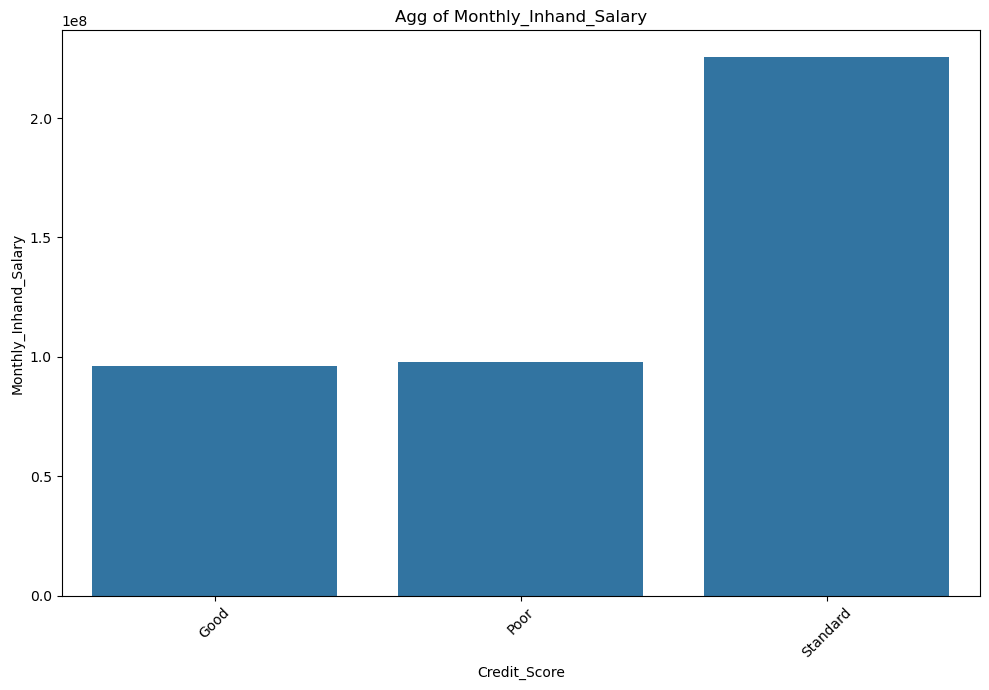

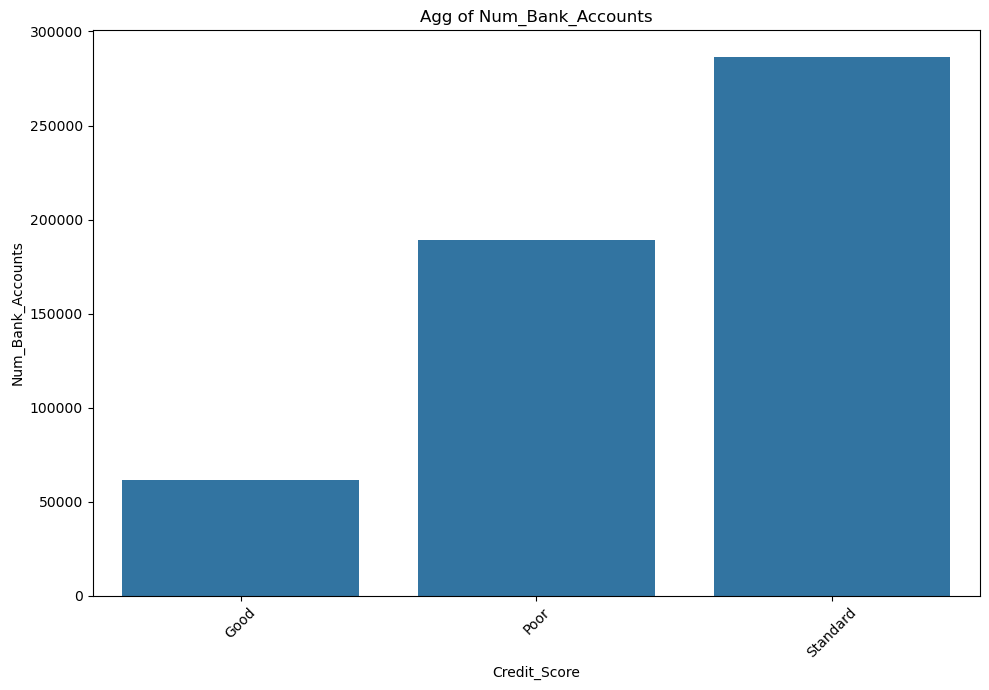

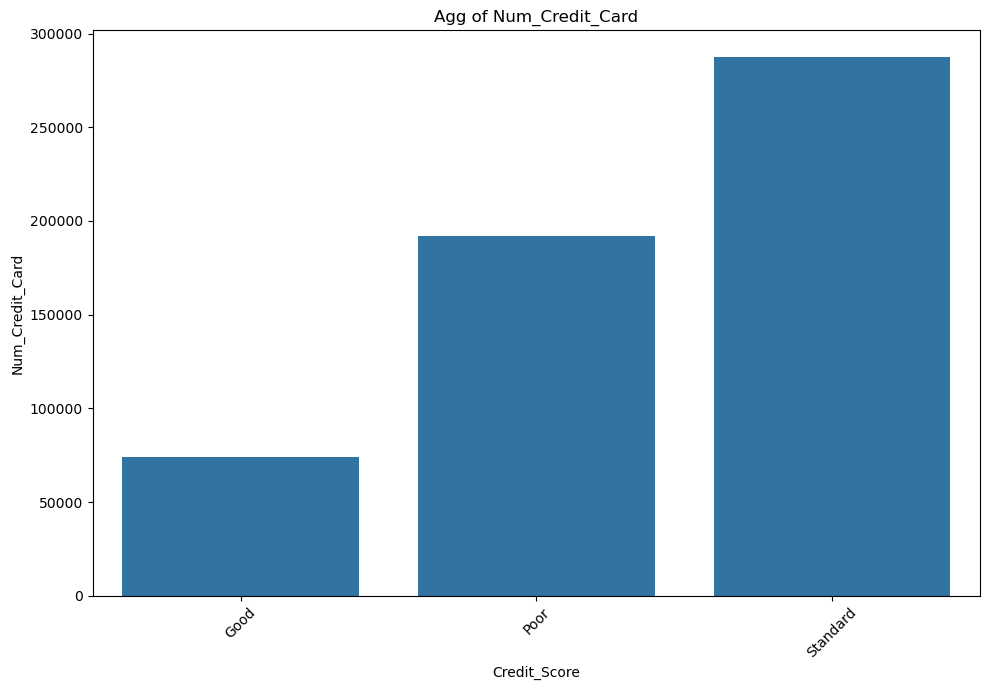

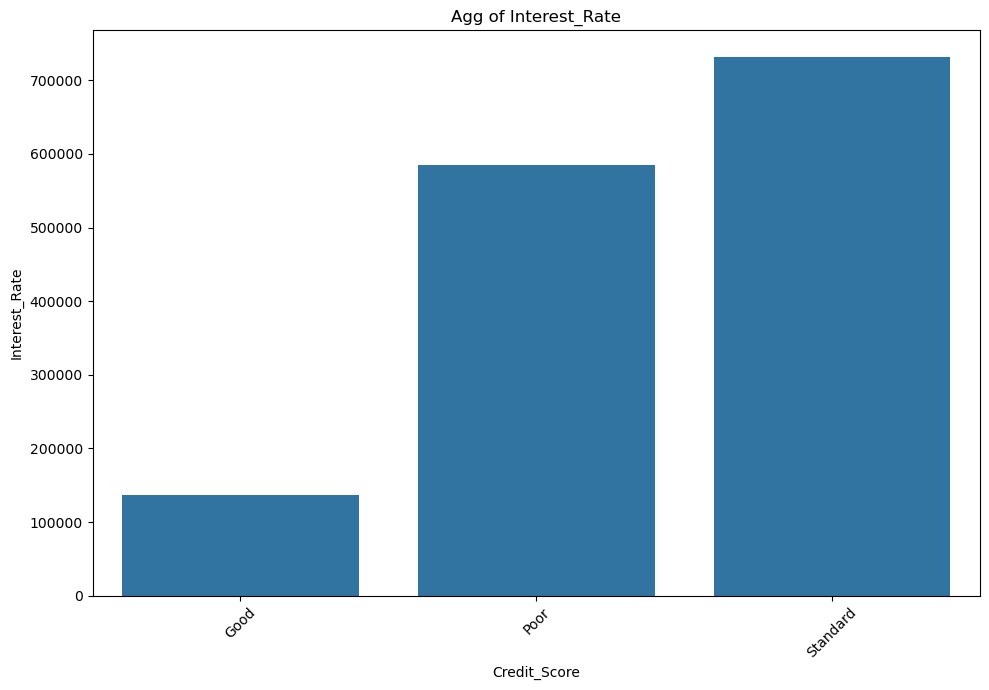

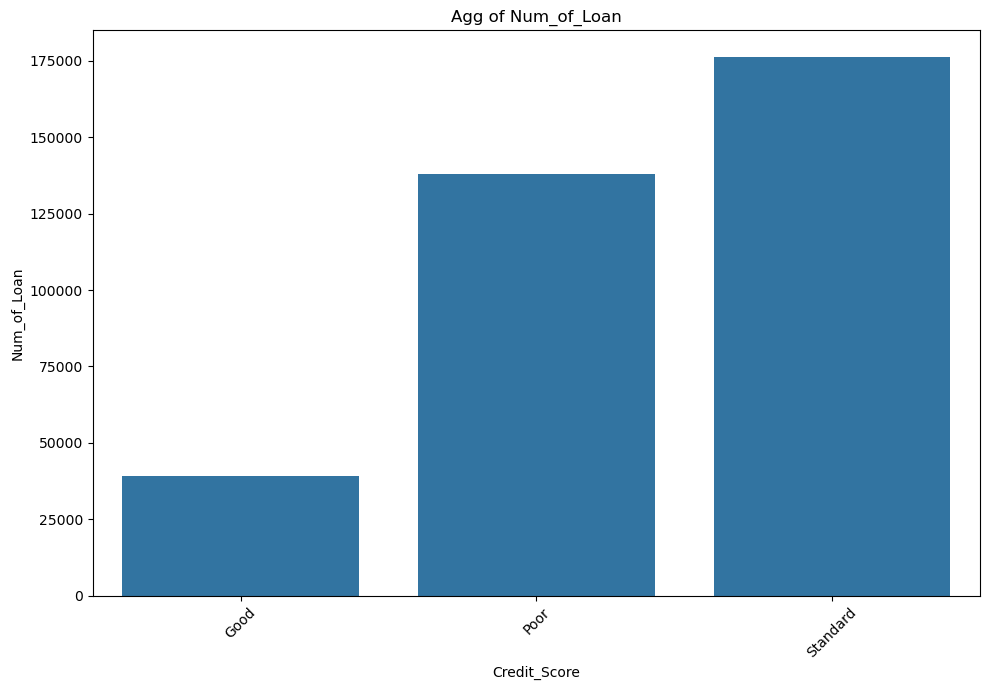

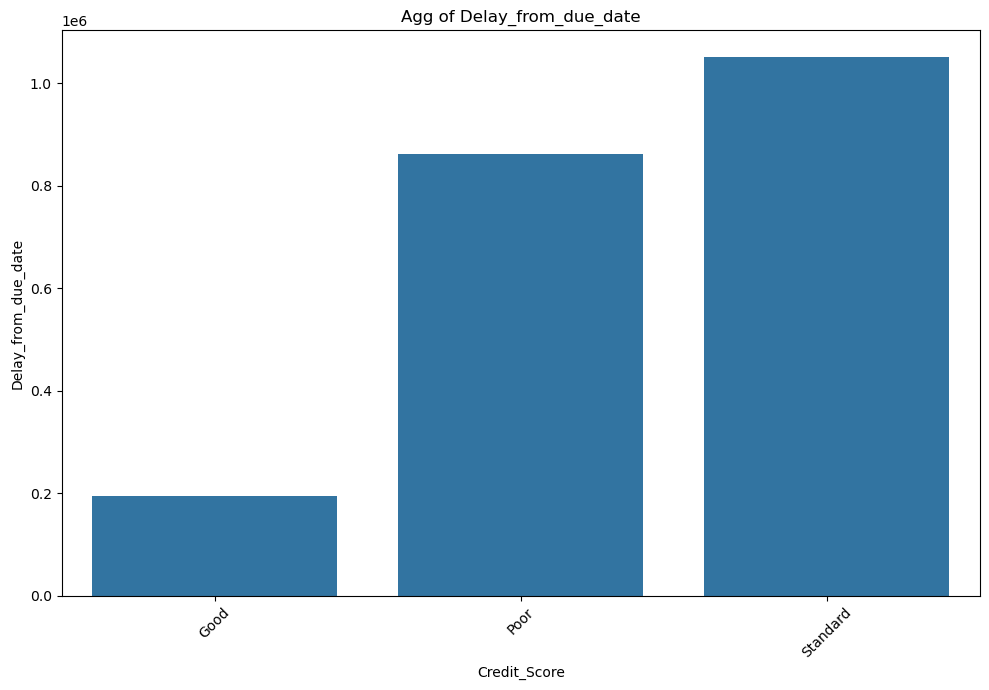

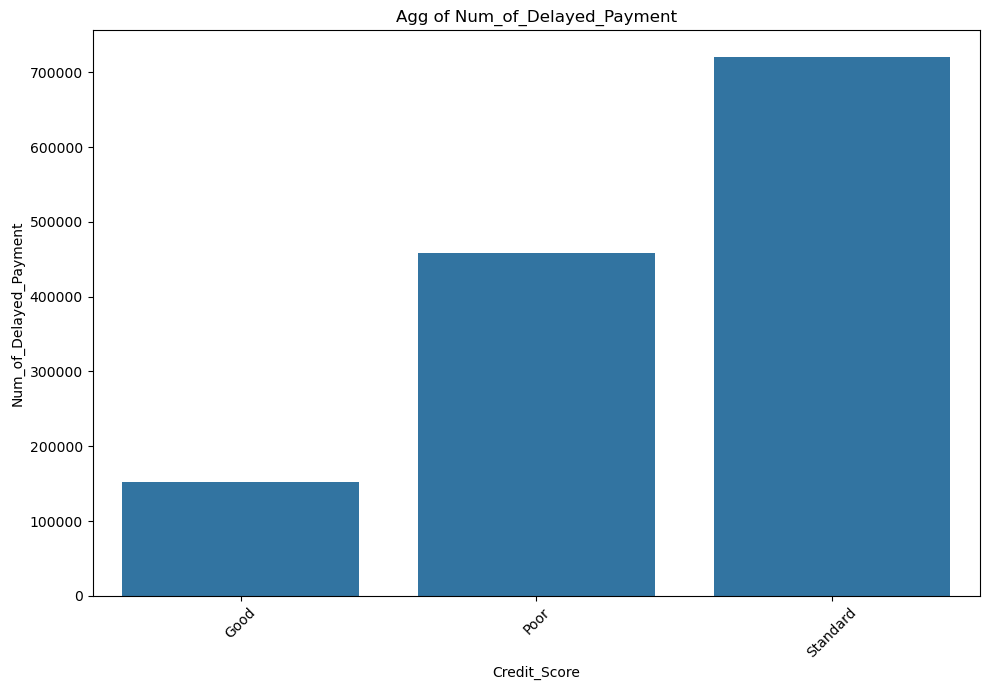

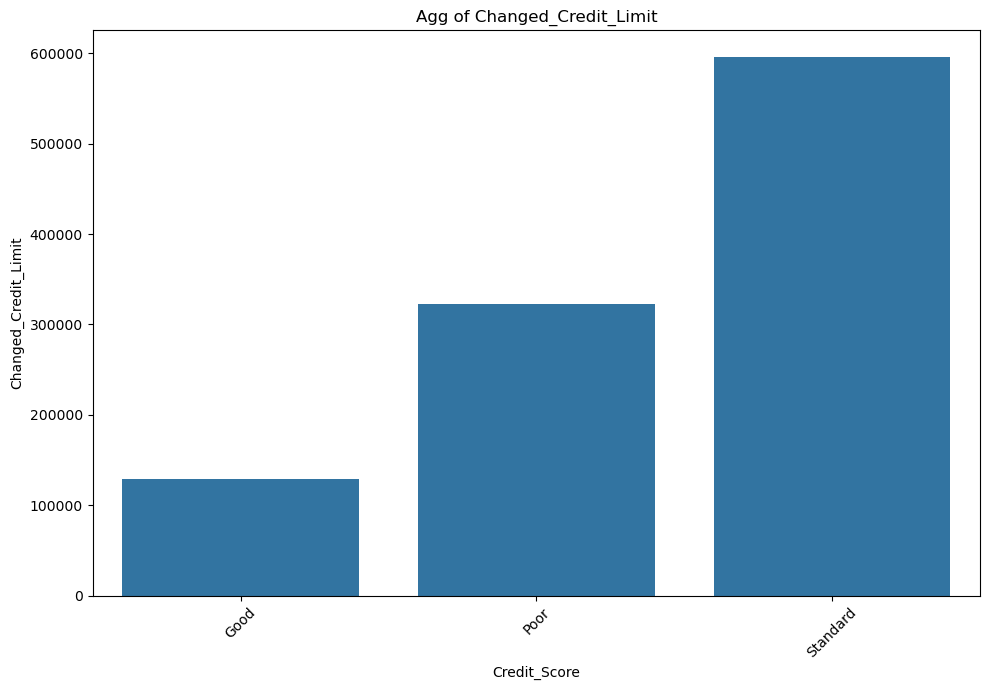

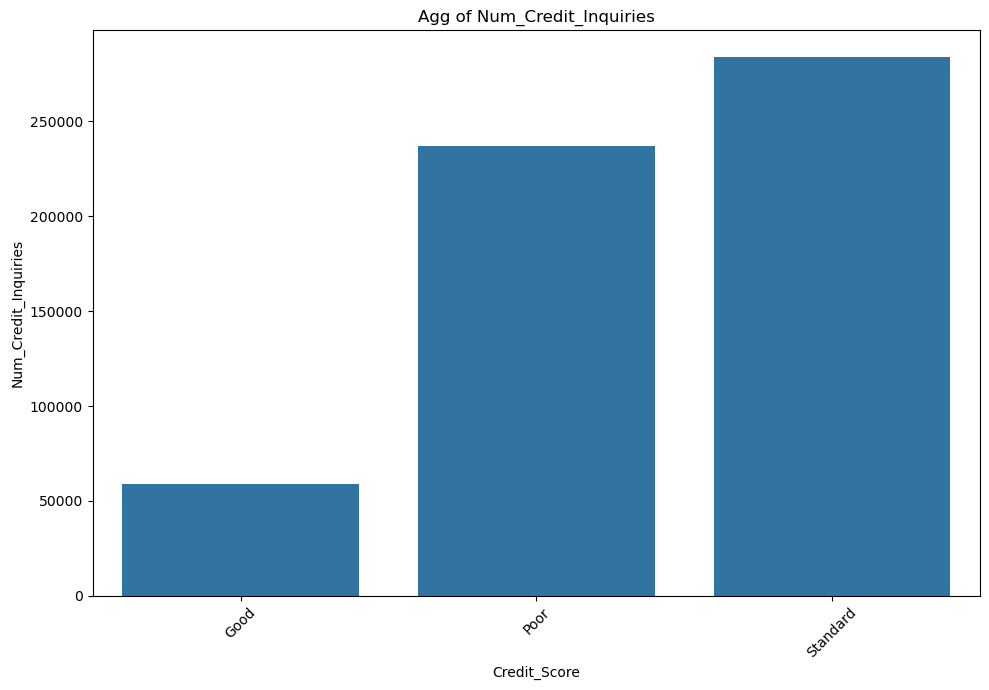

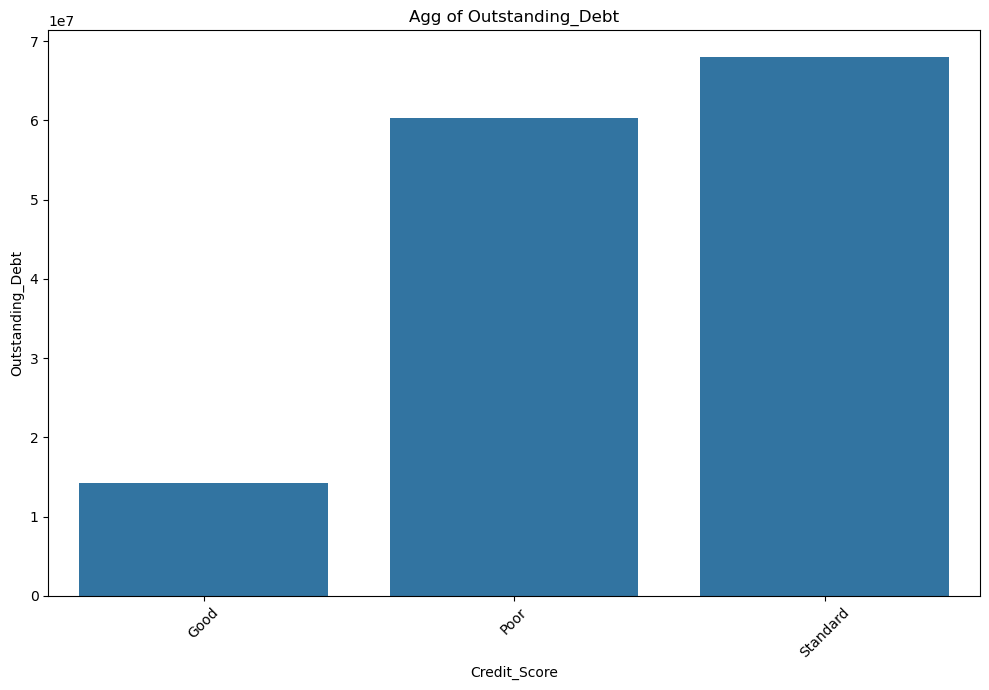

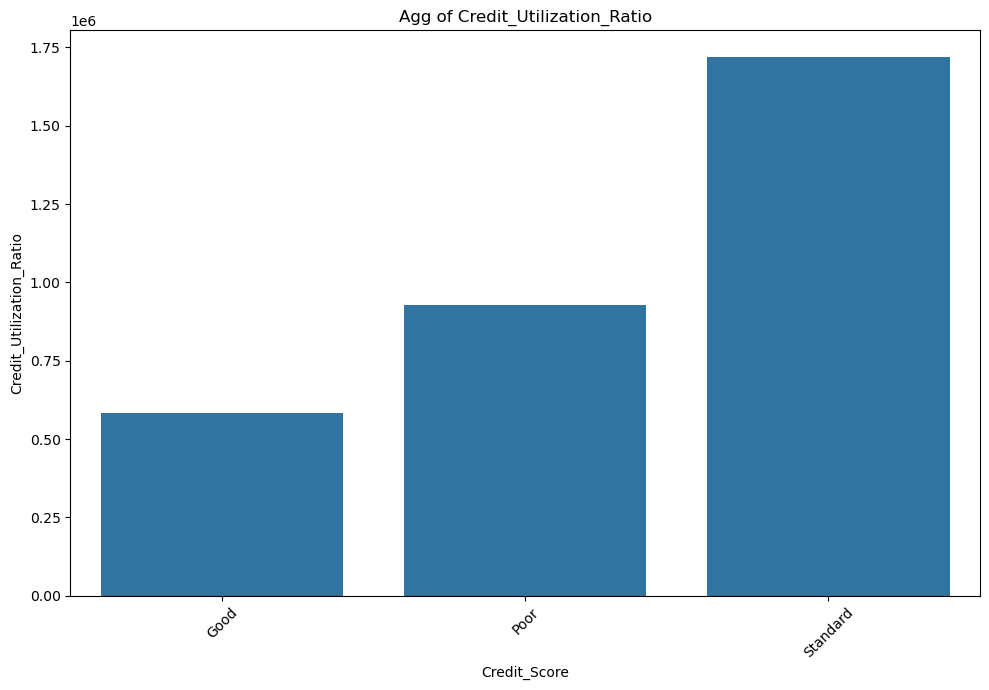

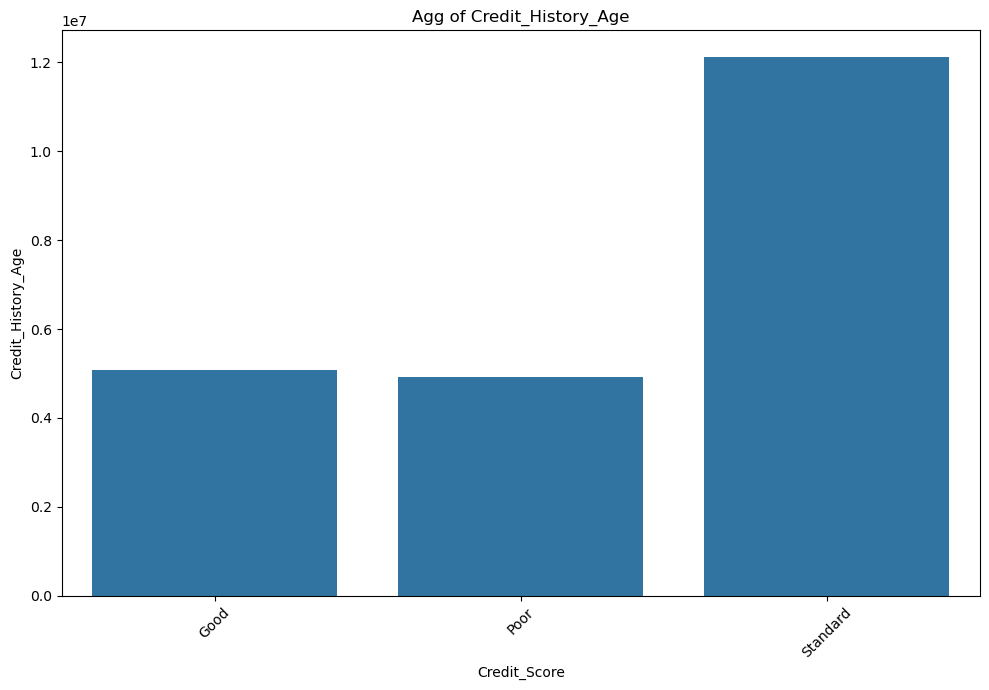

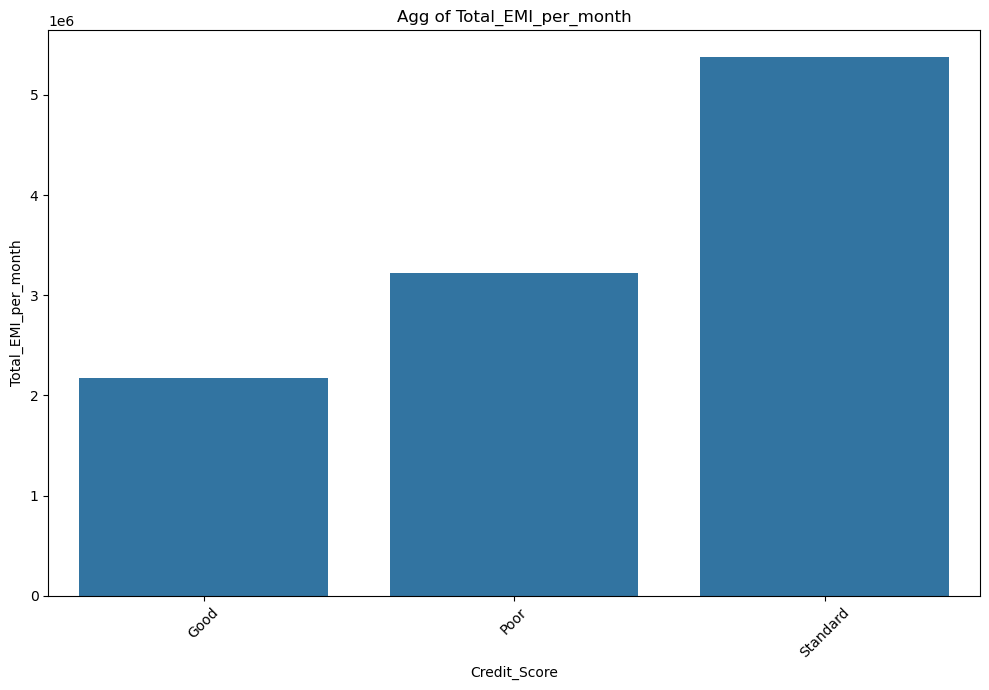

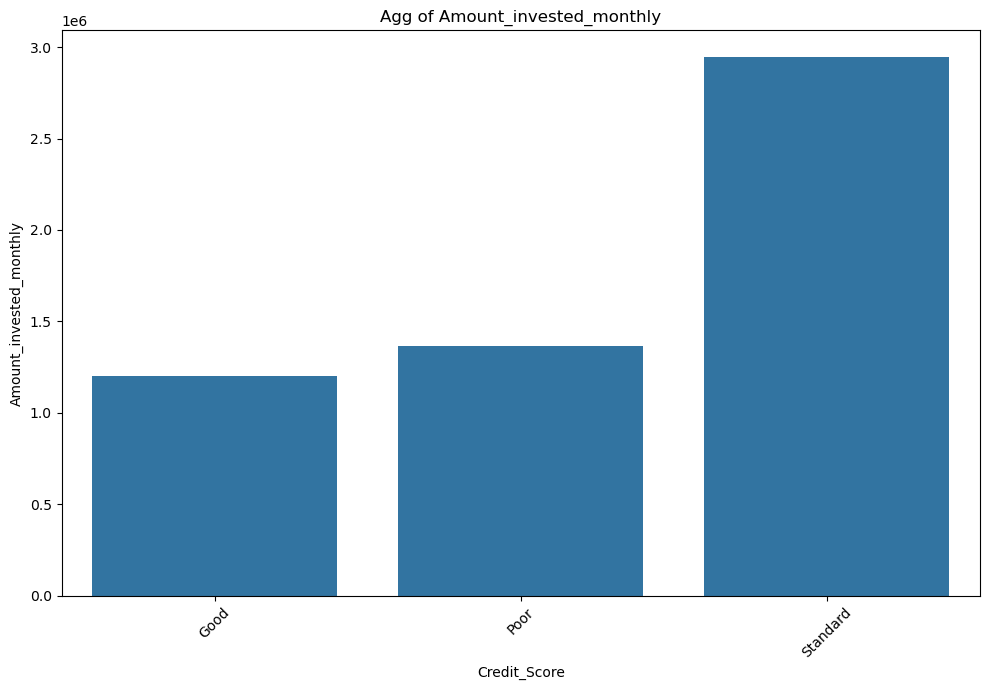

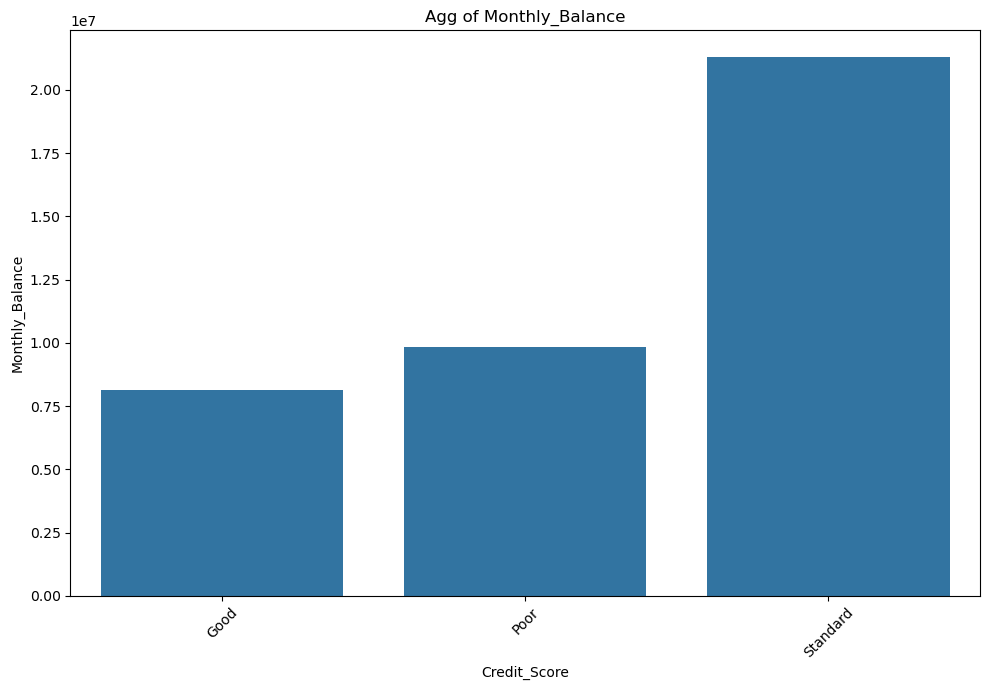

In [20]:
for col in numeric_cols.columns:
  aggregate_dataset(df, "Credit_Score", col, "sum")

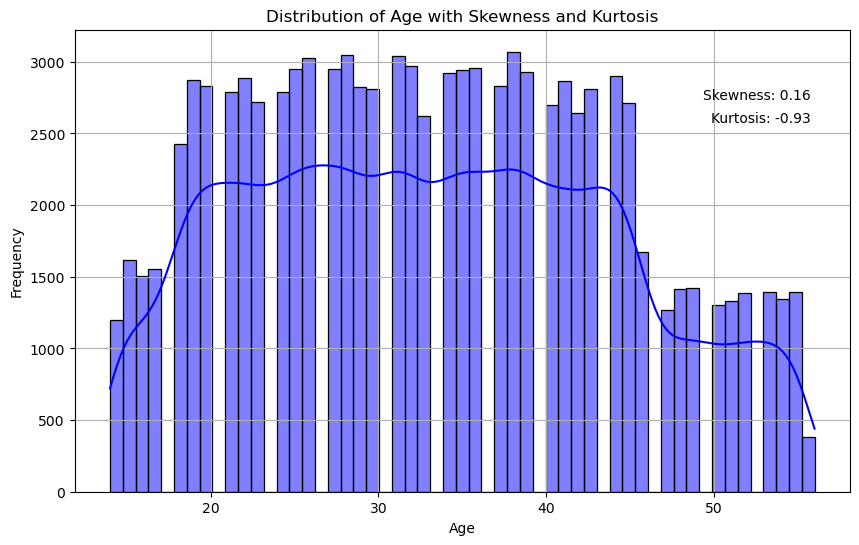

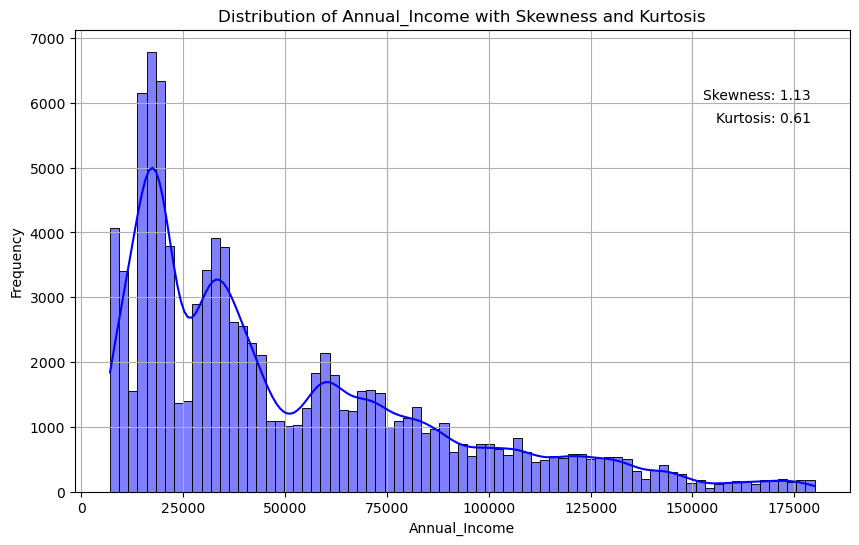

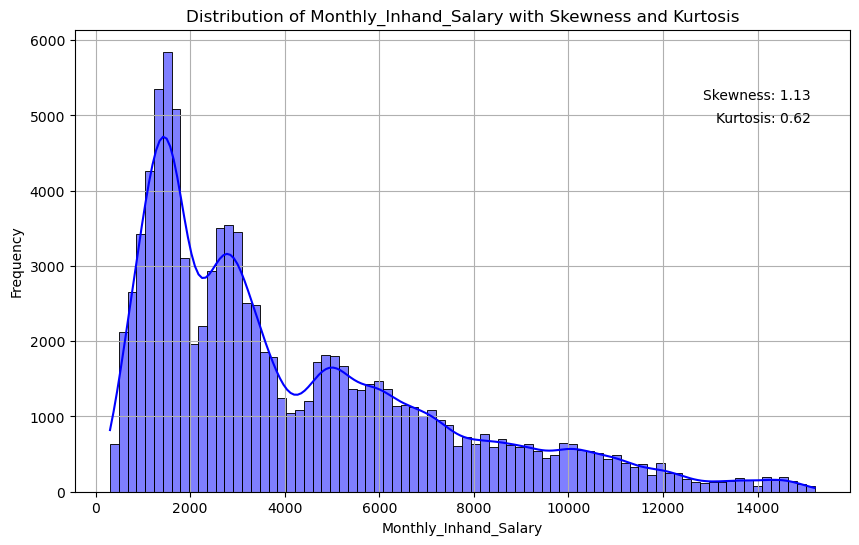

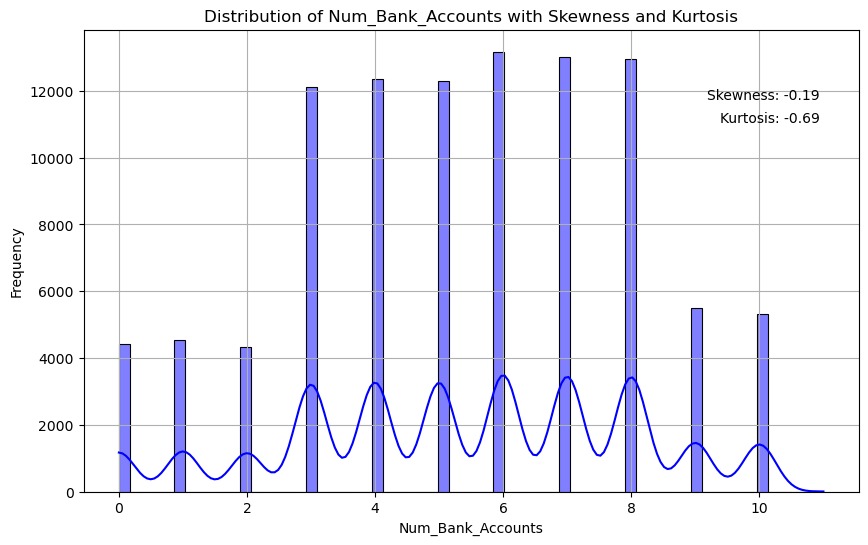

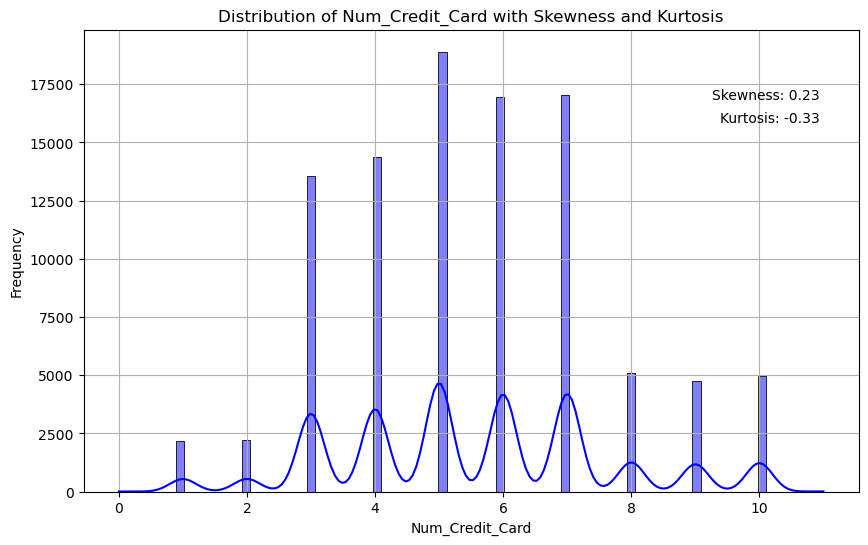

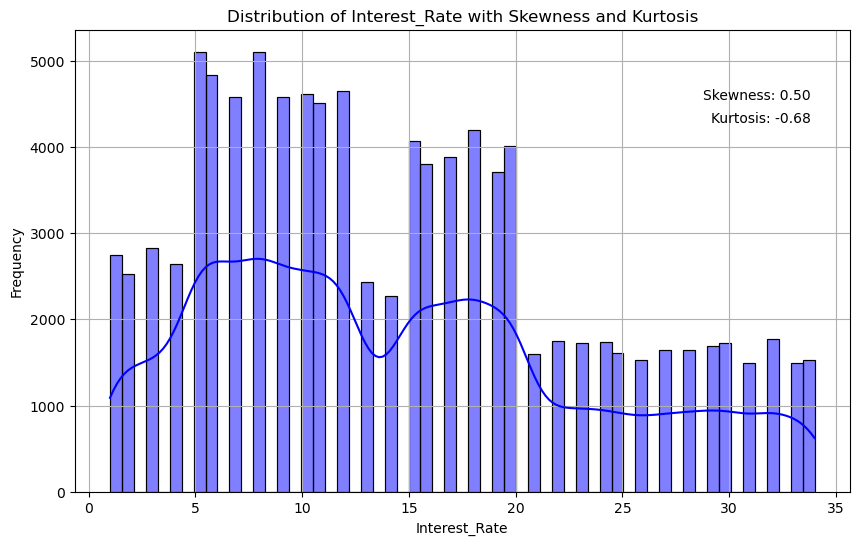

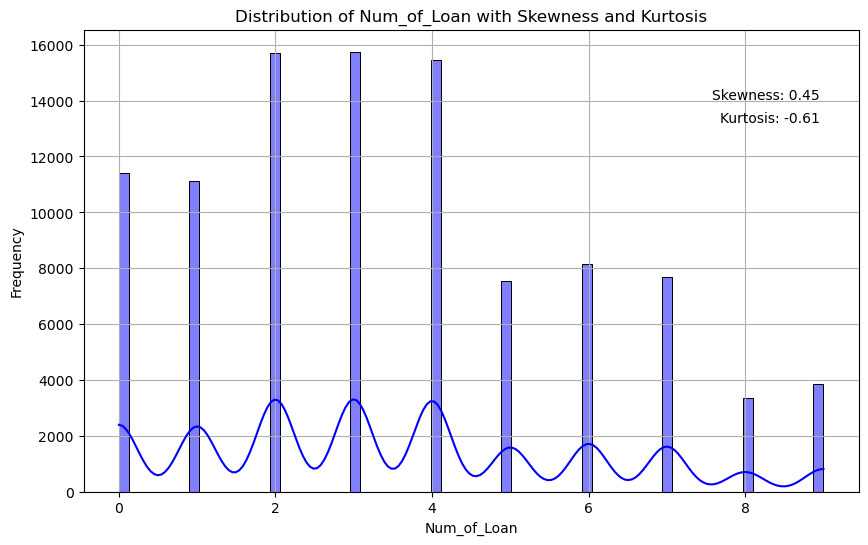

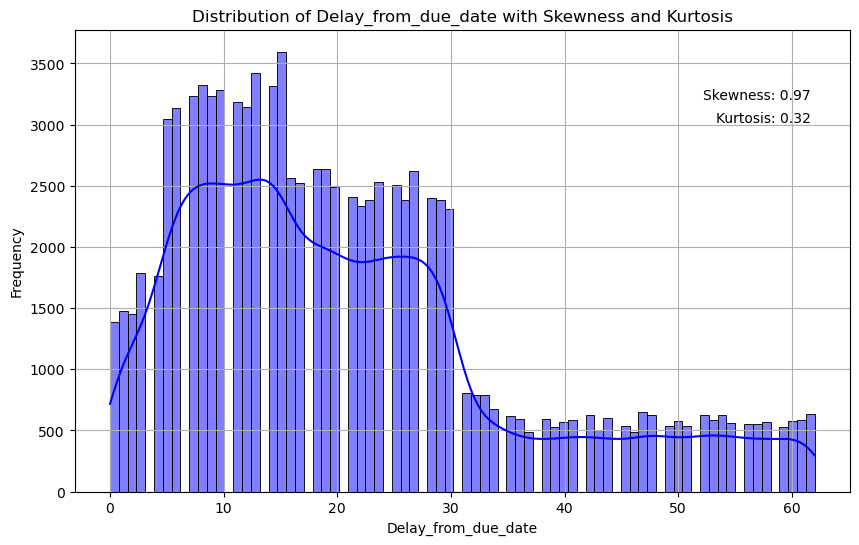

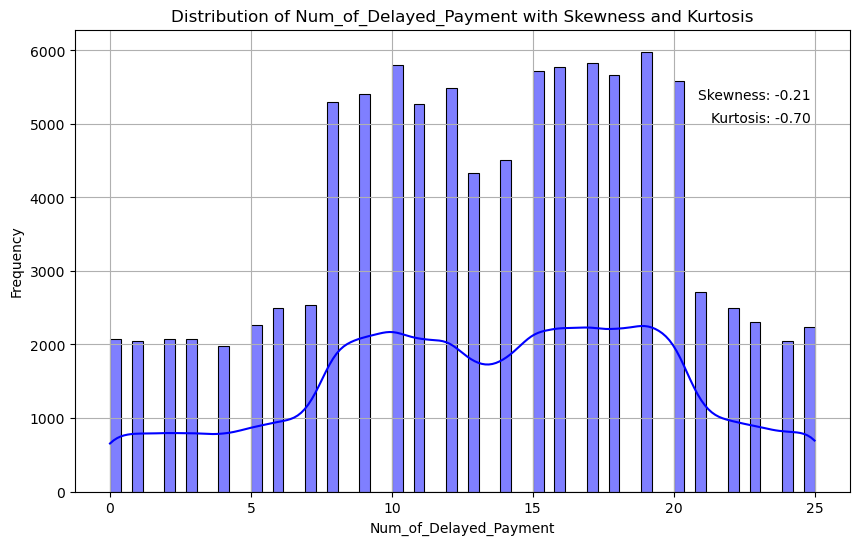

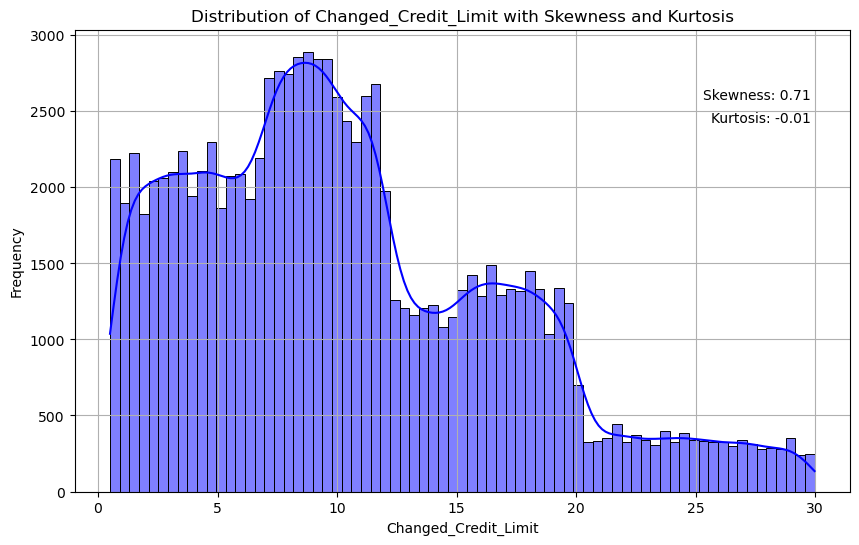

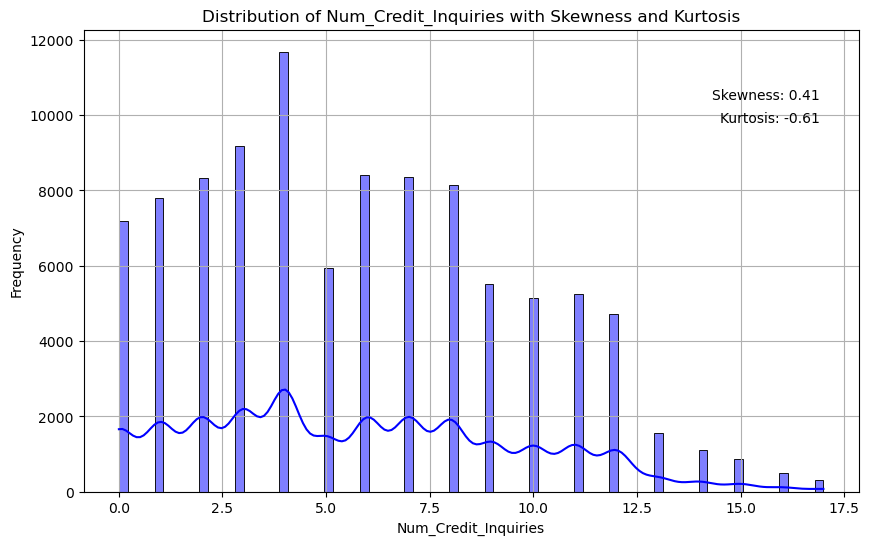

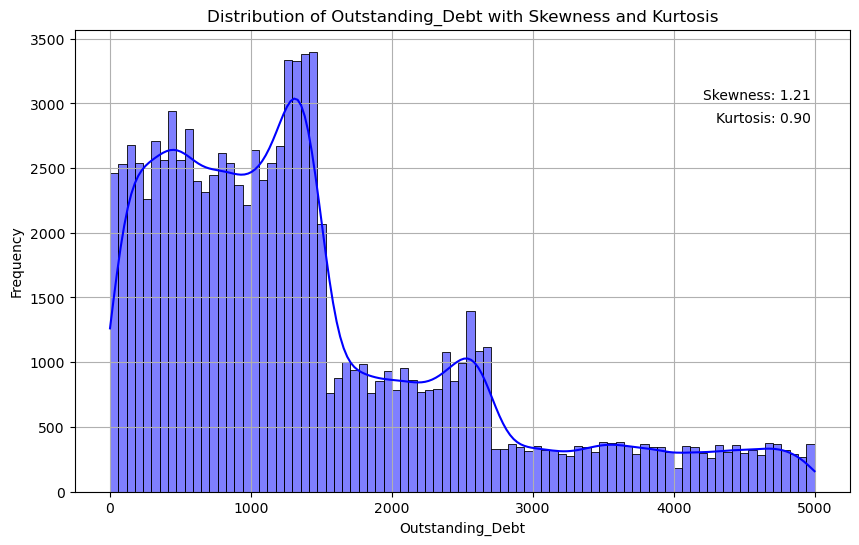

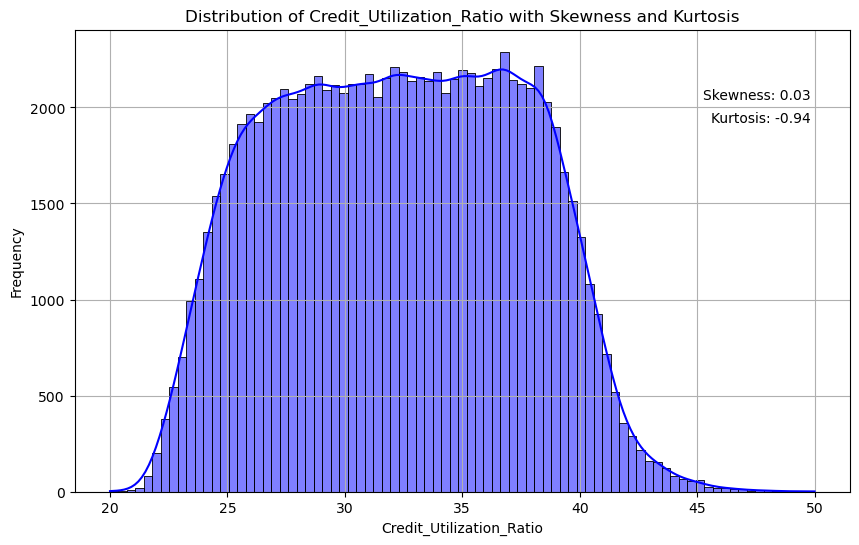

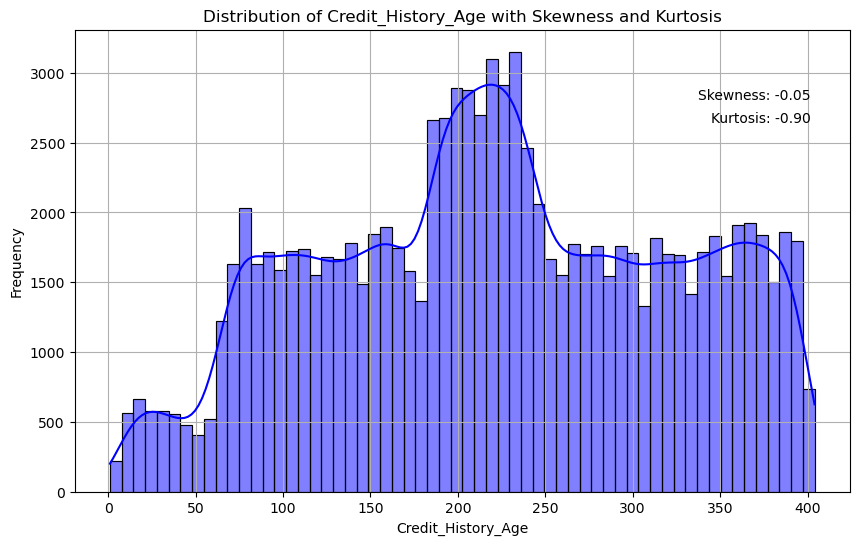

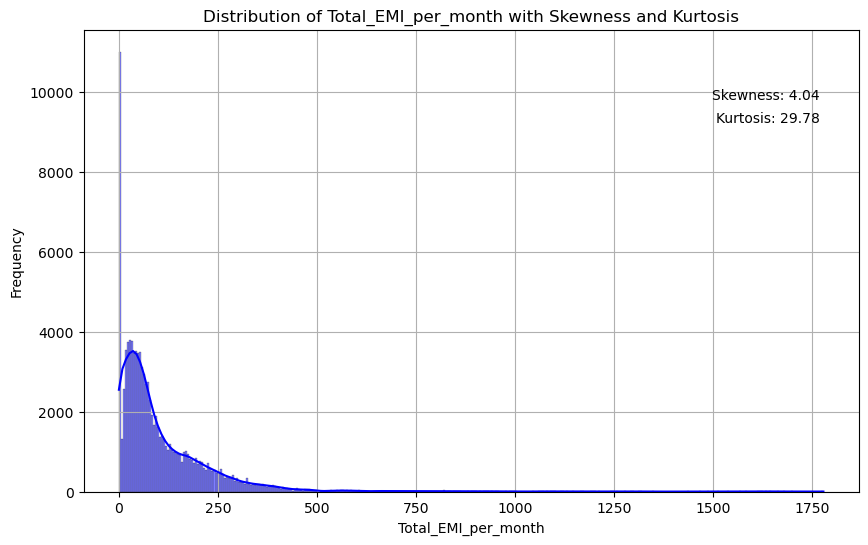

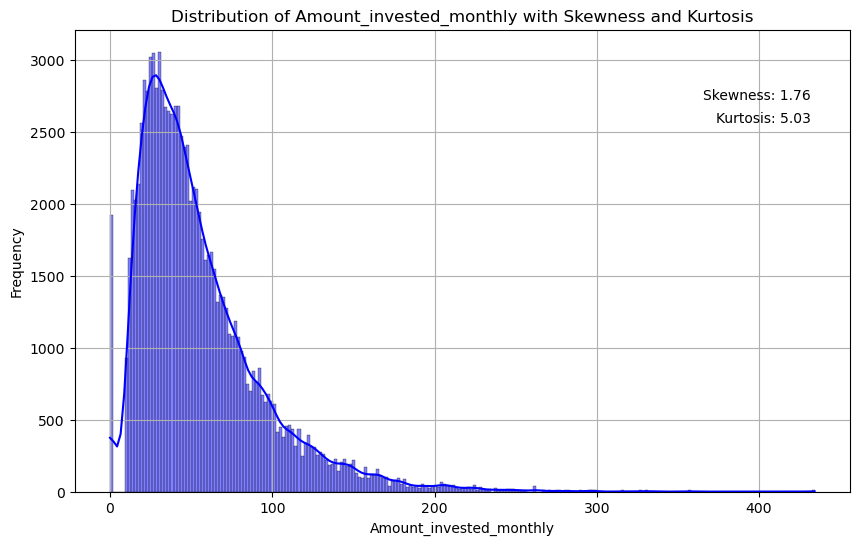

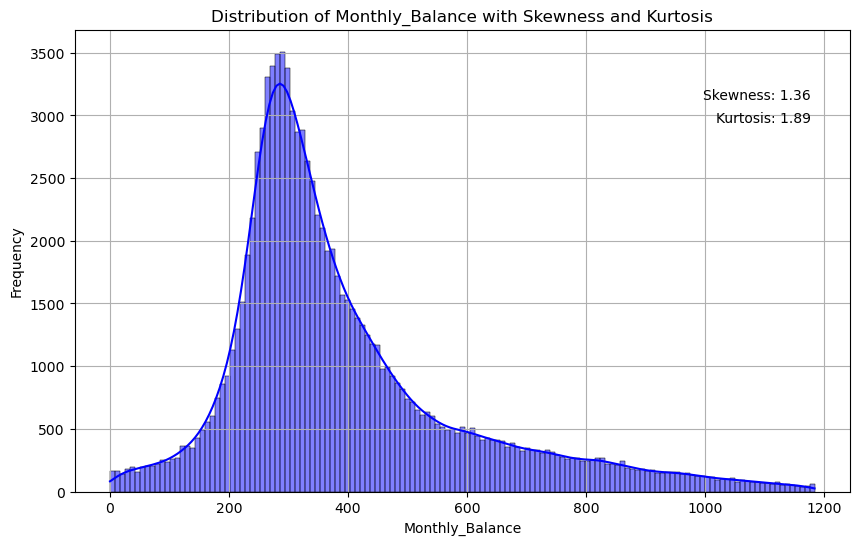

In [21]:
for col in numeric_cols.columns:
  dist_plot(df, col)

# Separate X and y variables

In [22]:
X, y = df.drop("Credit_Score", axis=1), df["Credit_Score"]

In [26]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Metrics to Score

In [23]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Create Preprocessor

In [24]:
preprocessor = create_column_transformer(cat_cols.columns, numeric_cols.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object'))])

# PCA Analysis

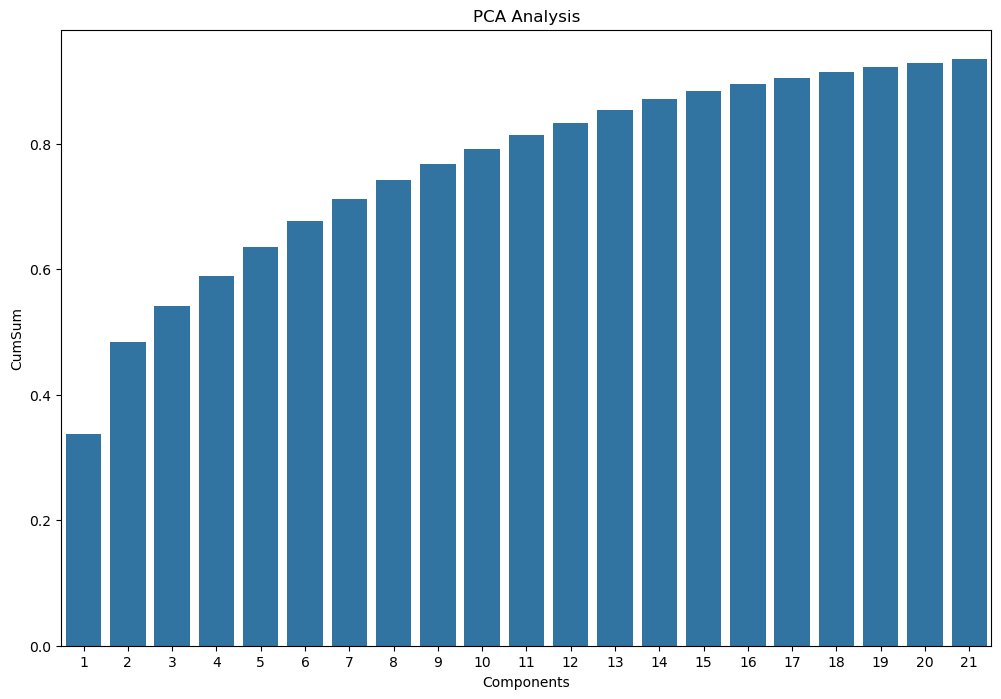

    Component    CumSum
0           1  0.338225
1           2  0.483437
2           3  0.541203
3           4  0.589155
4           5  0.635028
5           6  0.677693
6           7  0.712521
7           8  0.742278
8           9  0.768436
9          10  0.792242
10         11  0.813546
11         12  0.833541
12         13  0.853387
13         14  0.871377
14         15  0.883829
15         16  0.895293
16         17  0.905308
17         18  0.914146
18         19  0.922356
19         20  0.928803
20         21  0.935080


In [25]:
pca_analysis(X, preprocessor)

# Variance Stalls around 14-21 columns

# Test Baseline Model

In [28]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

   Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.333  0.0  0.005     0.332         0.333            0.333     0.317


# Test K Best Columns

In [32]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)